In [9]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
from ipypb import track
import seaborn as sn
import warnings
import traceback
from collections.abc import Iterable

### Set directories

In [3]:
os.chdir("E:/University College London/O'Sullivan, Aidan - SDG6/")
s_path = './Landsat/Scenes/'

### Read in sites data

In [5]:
sites = pd.read_pickle("sites4.p")
#sites = sites.reset_index().set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')
#sites = sites.drop(columns=['monitoringSiteIdentifier','wbid','thematicId'])

In [21]:
corrected = len(os.listdir('./Landsat data/Corrected data V2'))
downloaded = len(os.listdir('./Landsat data/Cropped level 1 data'))

f'Downloaded = {downloaded} Corrected = {corrected}'

'Downloaded = 1059919 Corrected = 505160'

<br>

### Checking missing files from processing

In [45]:
cor_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data V2/")
cor_files = [i for i in cor_files if 'cloud' not in i]
cor_files = [i for i in cor_files if 'cirrus' not in i]
cor_files = [i for i in cor_files if 'B6' not in i]
cor_files = [i.replace('_sre.tif','') for i in cor_files]

## list of files already processed
l1_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Cropped level 1 data/")
l1_files = [i.replace('.TIF','') for i in l1_files]
l1_files = [i for i in l1_files if 'B6' not in i]
l1_files = [i for i in l1_files if 'txt' not in i]
l1_files = [i for i in l1_files if 'BQ' not in i]

cor_files[1:5],l1_files[1:5]

In [47]:
missing =  [i for i in l1_files if i not in cor_files ]
len(missing)
missing

13344

In [50]:
incorrect =  [i for i in cor_files if i not in l1_files ]
len(incorrect)
incorrect

40

### Correction failures

In [25]:
corex = pd.read_csv("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/ac corrections.csv")

In [26]:
corex.call.unique()

array(['[, tf, idx, 1',
       'if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0. DOS-based approaches don\'t make sense in this case.")',
       'radCor, ras_stack, meta_data, costz', '[, tf, , 1', 'read meta'],
      dtype=object)

In [27]:
corex[corex.call=='if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0. DOS-based approaches don\'t make sense in this case.")'].head()

Unnamed: 0           sid                                       eid  \
2           3  ATSE20501000  LC08_L1TP_191028_20150412_20170410_01_T1   
3           4  ATSE20501000  LE07_L1TP_191027_20090825_20161220_01_T1   
4           5  ATSE20501000  LE07_L1TP_191027_20120326_20161203_01_T1   
5           6  ATSE20501000  LE07_L1TP_191027_20120918_20161129_01_T1   
6           7  ATSE20501000  LE07_L1TP_191028_20111119_20161205_01_T1   

                                                call  \
2  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
3  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
4  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
5  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
6  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   

                                   error  
2  missing value where TRUE/FALSE needed  
3                                   none  
4                                   none  
5                                   none  
6                                   none

### Checking duplicates in atmospheric correction

In [17]:
## costz
cor_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data V2/")
cor_files = [ i for i in cor_files if 'cloud' not in i]
cor_files = [ i for i in cor_files if 'cirrus' not in i]
cor_files = [ i[:-8] for i in cor_files ]

## dos
cor2_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data toare/")
cor2_files = [ i for i in cor2_files if 'cloud' not in i]
cor2_files = [ i for i in cor2_files if 'cirrus' not in i]
cor2_files = [ i[:-8] for i in cor2_files ]
cor_files[1:5],cor2_files[1:5]

(['ATSE20101000__LE07_L1TP_191028_20100524_20161214_01_T1_B2',
  'ATSE20101000__LE07_L1TP_191028_20100524_20161214_01_T1_B3',
  'ATSE20101000__LE07_L1TP_191028_20100524_20161214_01_T1_B4',
  'ATSE20101000__LE07_L1TP_191028_20100524_20161214_01_T1_B5'],
 ['ATSE20301000__LE07_L1TP_191027_20110916_20161206_01_T1_B2',
  'ATSE20301000__LE07_L1TP_191027_20110916_20161206_01_T1_B3',
  'ATSE20301000__LE07_L1TP_191027_20110916_20161206_01_T1_B4',
  'ATSE20301000__LE07_L1TP_191027_20110916_20161206_01_T1_B5'])

In [18]:
duplicates =  [i for i in cor2_files if i in cor_files ]
print(f'Duplicates: {len(duplicates)} All files: {len(cor2_files)}')
duplicates

Duplicates: 4 All files: 13315


['PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1_B4',
 'PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1_B5',
 'PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1_B6_VCID_',
 'PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1_B6_VCID_']

In [14]:
### Remove duplicates files

path = "C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data toare/"

for dup in duplicates:
    os.remove(path+dup+'_tre.tif')

FileNotFoundError: [WinError 2] The system cannot find the file specified: "C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data toare/PL01S0202_0069__LE07_L1TP_190022_20141003_20161101_01_T1_B6_VCID__tre.tif"

### Check for bad striping in failed correction

In [98]:
temp = corex[corex.call=='if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0. DOS-based approaches don\'t make sense in this case.")']
temp = temp.reset_index().drop(['index','Unnamed: 0'],axis=1)
temp.head(2)

sid                                       eid  \
0  ATSE20501000  LC08_L1TP_191028_20150412_20170410_01_T1   
1  ATSE20501000  LE07_L1TP_191027_20090825_20161220_01_T1   

                                                call  \
0  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
1  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   

                                   error  
0  missing value where TRUE/FALSE needed  
1                                   none

In [99]:
temp['naprop'] = pd.Series(dtype=np.float,index=temp.index)
for i in track(range(0,len(temp))):
    src_path = c1_path+temp.iloc[i].sid+'__'+temp.iloc[i].eid+'_B2.tif'
    
    try: 
        with rio.open(src_path) as src:

            data = src.read(1)
            temp.loc[i,'naprop'] = data[data>0].size/data.size
            #print(ratio)
    
        src.close()        
    except:
        print(f'source not found for {temp.iloc[i,:].sid}__{temp.iloc[i,:].eid}')
        
temp.head(5)

 [████████████████████████████████████████████████████████████] 3157/3157 [01:11<00:00, 0.02s/it]

source not found for FISW_734__LC08_L1TP_187018_20170811_20170824_01_T1
source not found for PL01S0202_0069__LE07_L1TP_190022_20141003_20161101_01_T1
source not found for PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL01S0202_3357__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3320__LC08_L1TP_193023_20130826_20170502_01_T1
source not found for PL02S0102_3330__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3331__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3351__LE07_L1TP_191022_20140807_20161111_01_T1


sid                                       eid  \
0  ATSE20501000  LC08_L1TP_191028_20150412_20170410_01_T1   
1  ATSE20501000  LE07_L1TP_191027_20090825_20161220_01_T1   
2  ATSE20501000  LE07_L1TP_191027_20120326_20161203_01_T1   
3  ATSE20501000  LE07_L1TP_191027_20120918_20161129_01_T1   
4  ATSE20501000  LE07_L1TP_191028_20111119_20161205_01_T1   

                                                call  \
0  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
1  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
2  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
3  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
4  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   

                                   error    naprop  
0  missing value where TRUE/FALSE needed  0.932857  
1                                   none  0.055445  
2                                   none  0.045326  
3                                   none  0.008313  
4                                   none  0.779199

number of tifs with less than 50% complete data 210


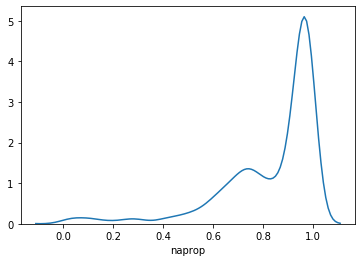

In [101]:
print(f'number of tifs with less than 50% complete data {len(temp[temp.naprop<0.5])}')
sn.distplot(temp.naprop,hist=False)

#### Plotting scenes

 [████████████████████████████████████████████████████████████] 130/130 [00:40<00:00, 0.30s/it]

53170
53170
53170
10380
97020
162176
38703
38703
204750
232104
34408
1077993
1032384
2870164
1118010
970898
1034180
59881
137740
137740
20590


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


2624


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


514917


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


514917


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47223


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47223


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


5977


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


474249


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


358005


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


374465


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


390925


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


374465


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


382695


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


8050


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


8050


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


9270


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


71380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91410


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91410


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


29380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


29380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


24964


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


24964


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


303601


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


303601


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11766


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


48208


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


298273


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


972000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


837000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


837000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1039500


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1081125


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1017000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1039500


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1062000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11375


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


9570


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91640


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11656


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1998


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


32832


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


32832


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


6205


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


88377


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


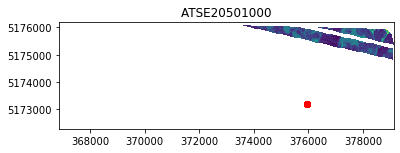

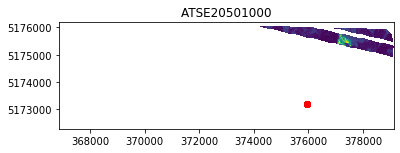

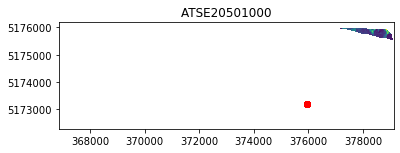

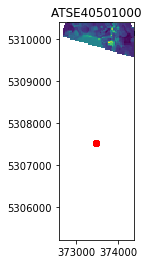

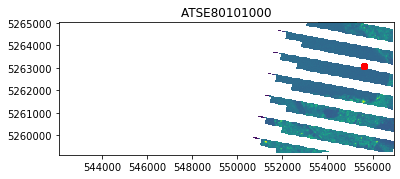

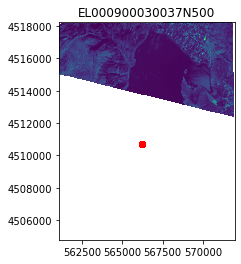

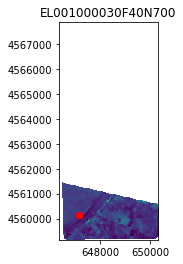

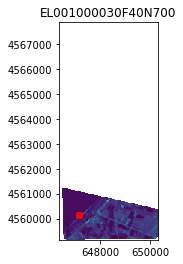

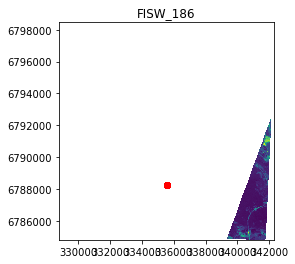

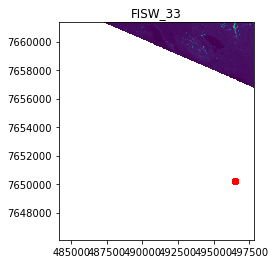

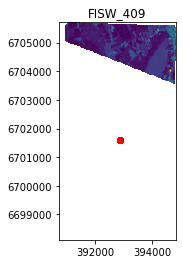

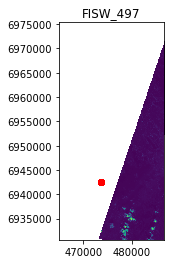

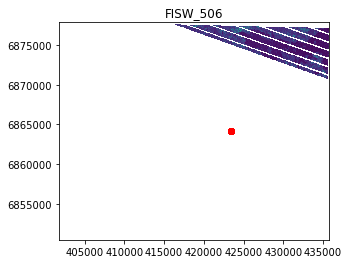

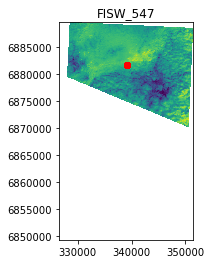

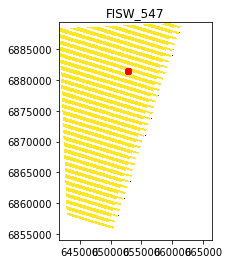

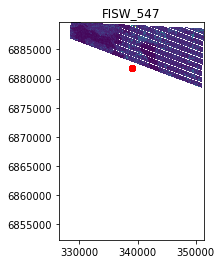

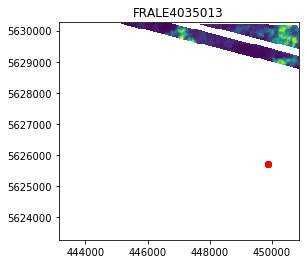

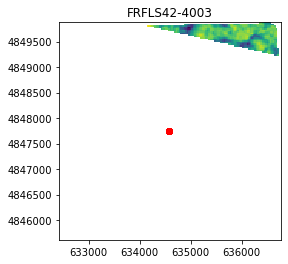

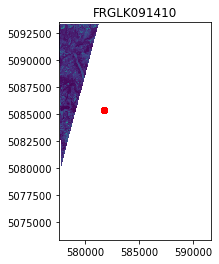

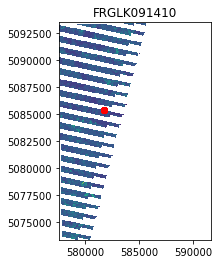

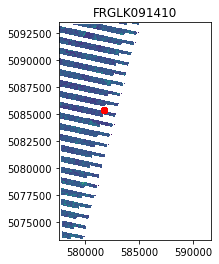

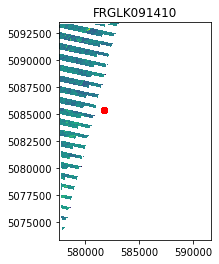

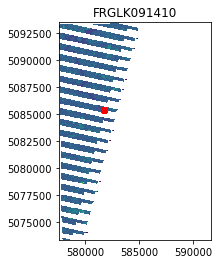

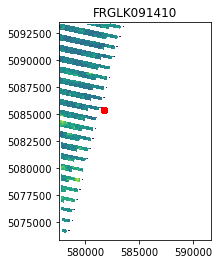

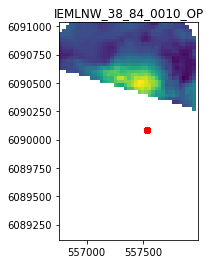

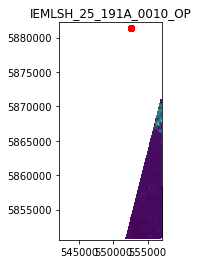

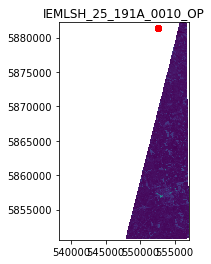

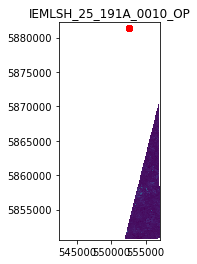

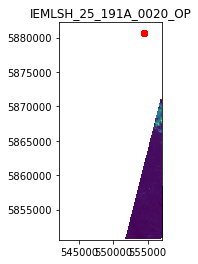

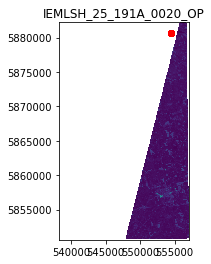

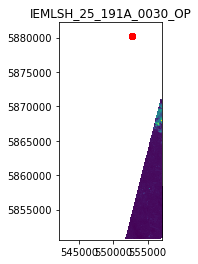

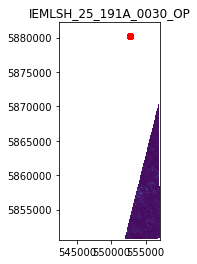

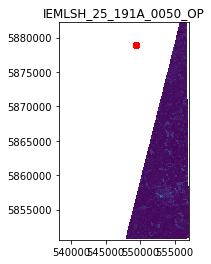

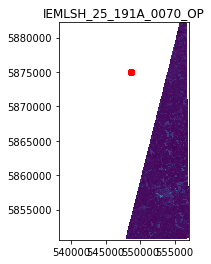

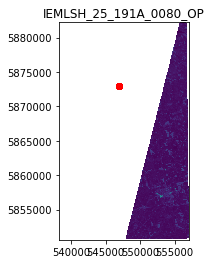

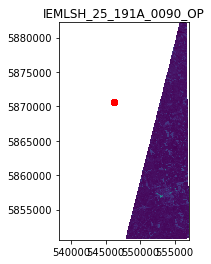

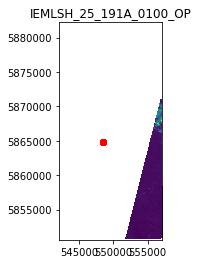

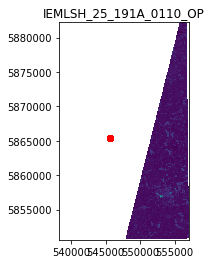

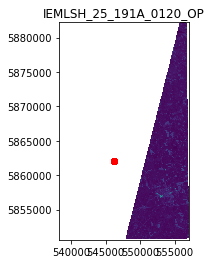

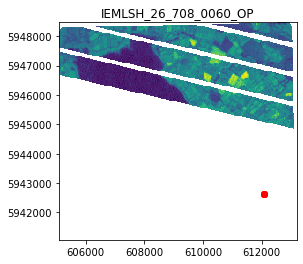

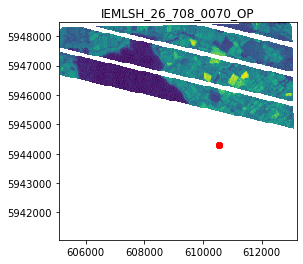

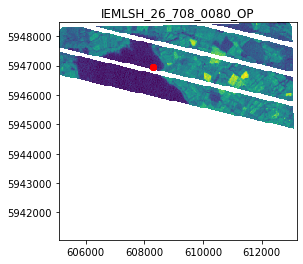

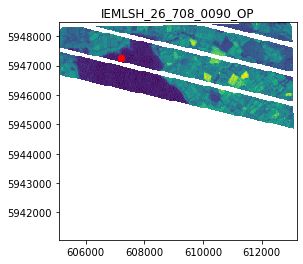

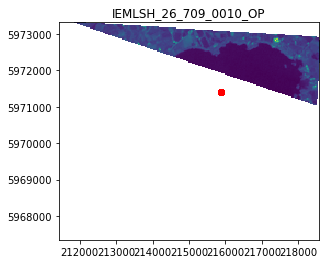

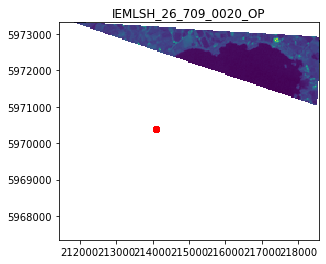

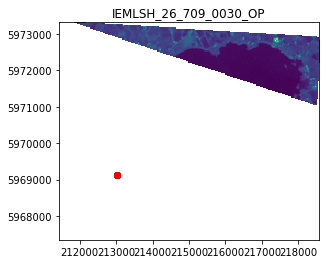

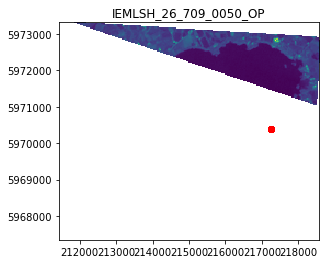

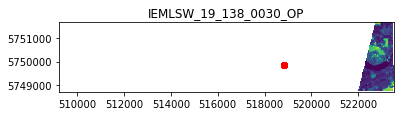

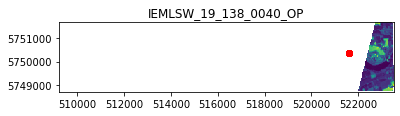

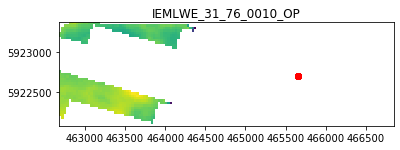

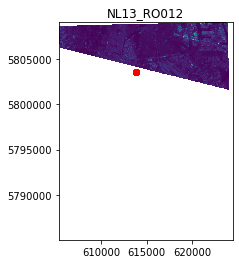

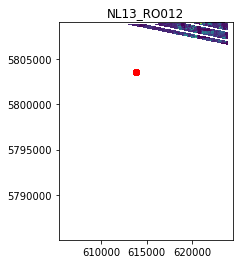

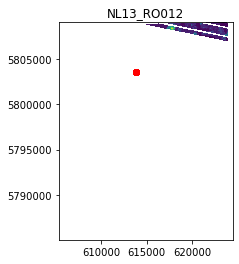

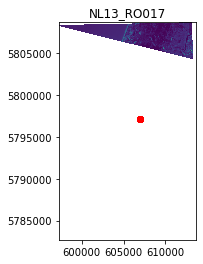

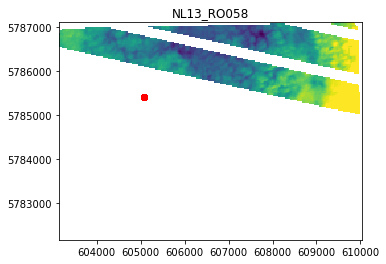

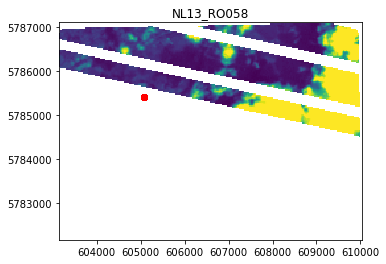

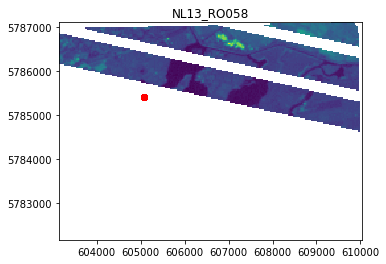

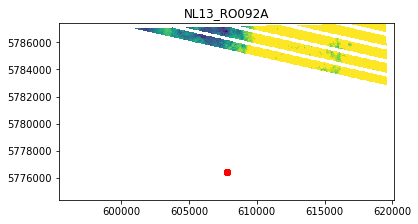

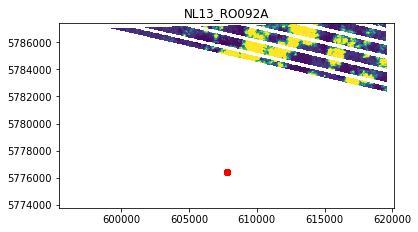

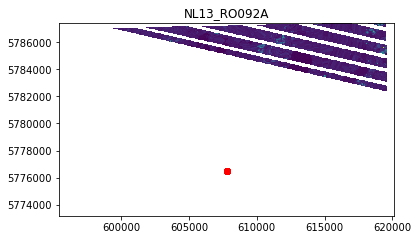

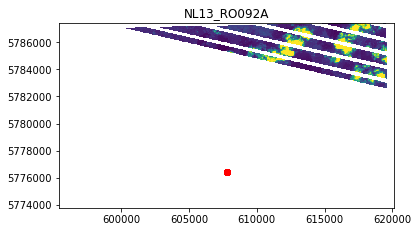

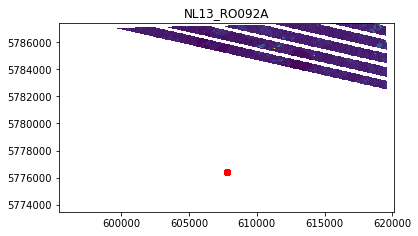

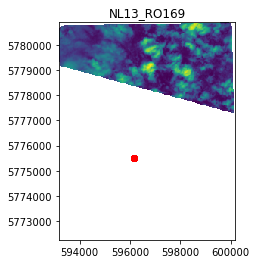

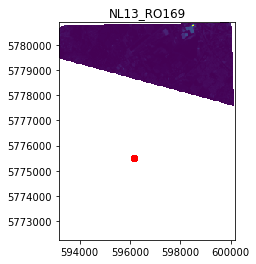

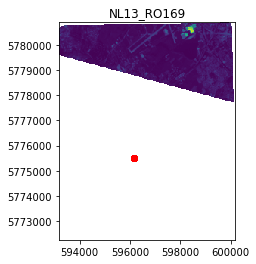

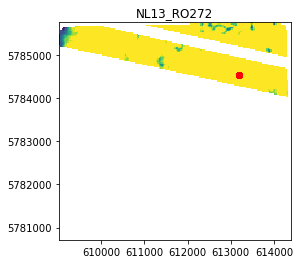

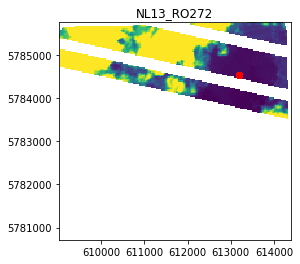

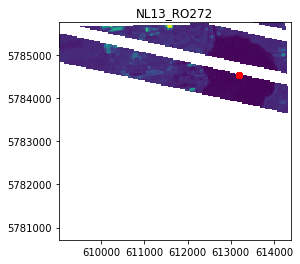

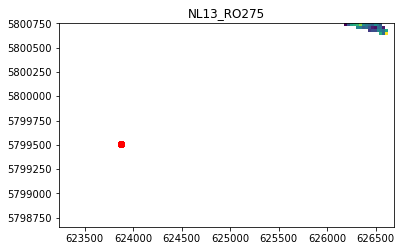

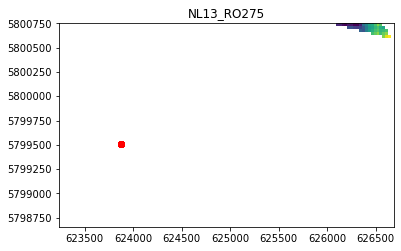

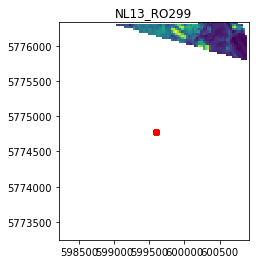

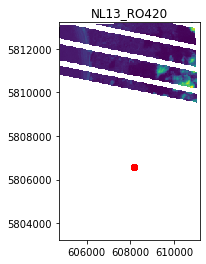

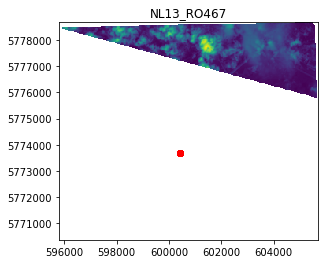

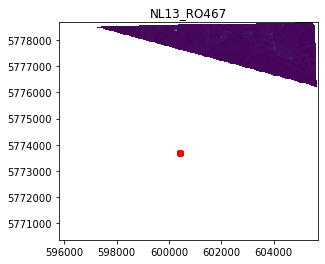

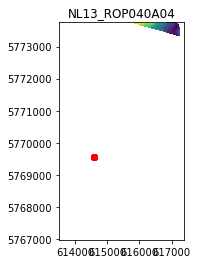

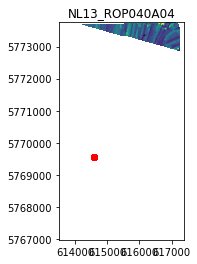

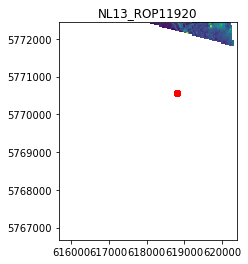

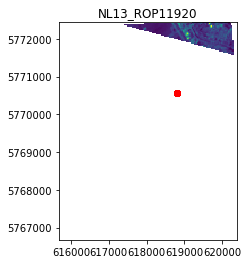

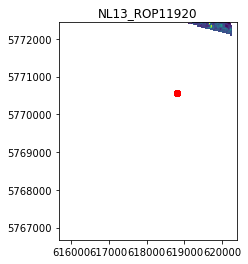

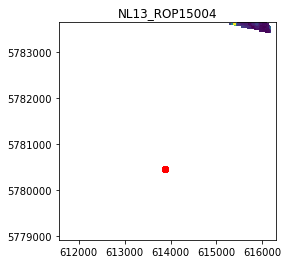

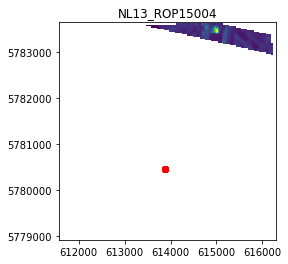

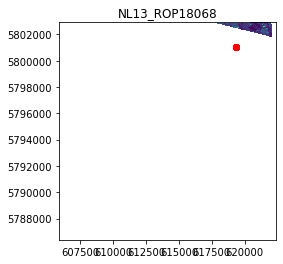

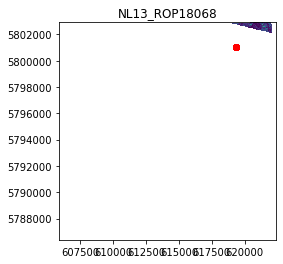

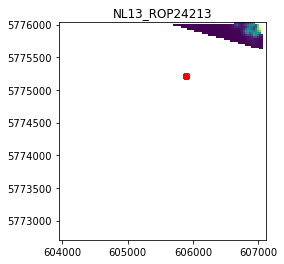

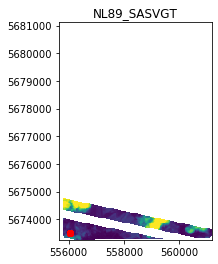

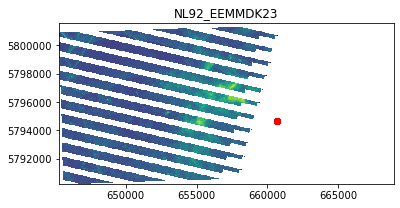

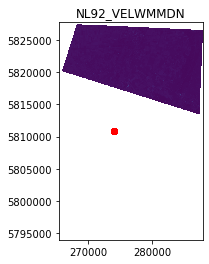

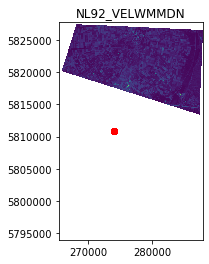

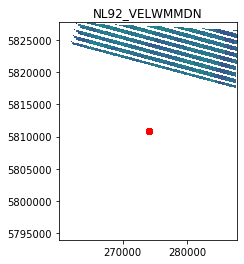

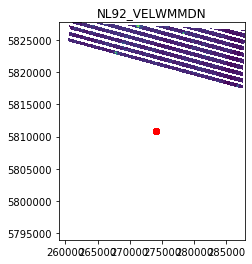

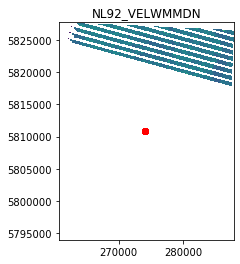

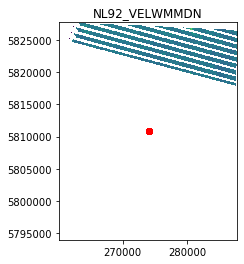

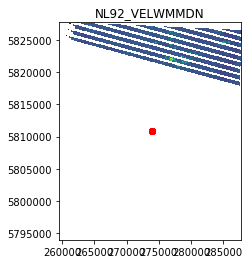

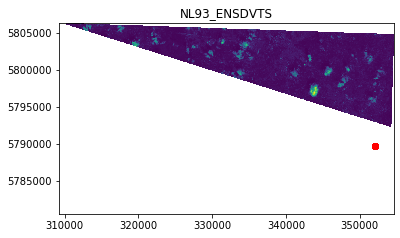

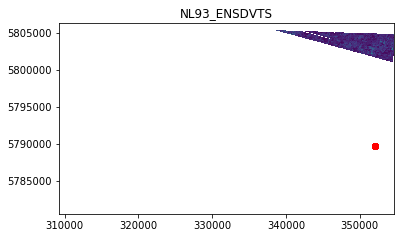

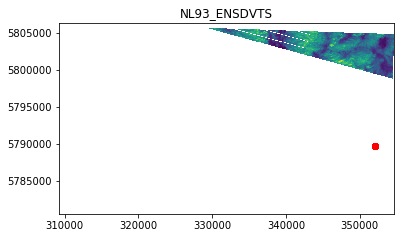

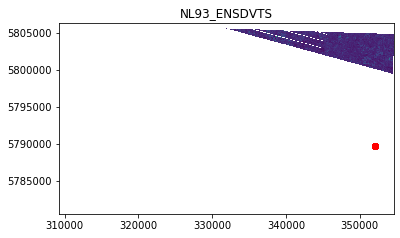

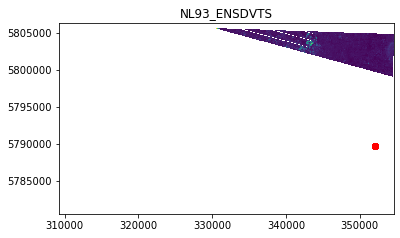

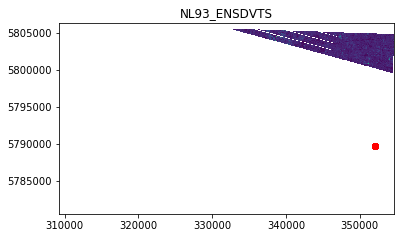

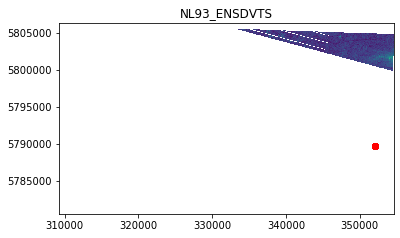

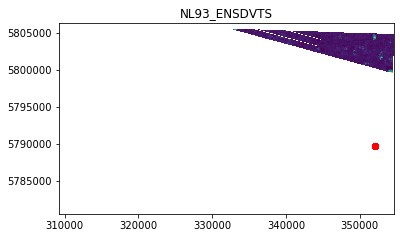

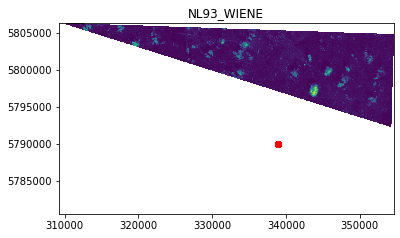

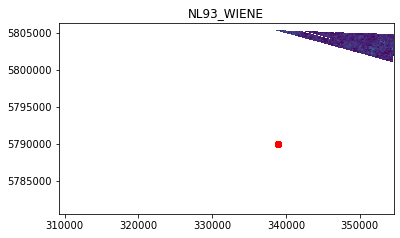

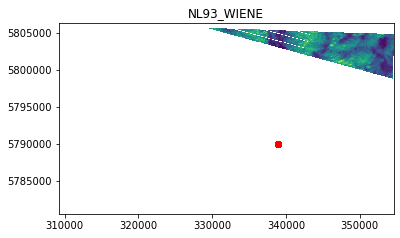

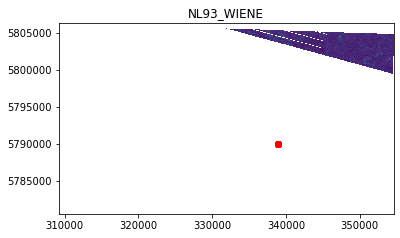

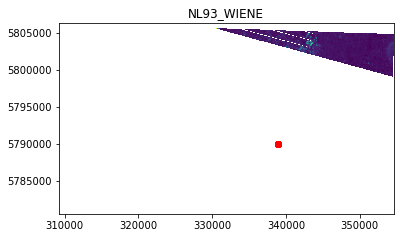

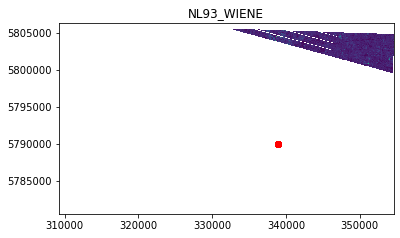

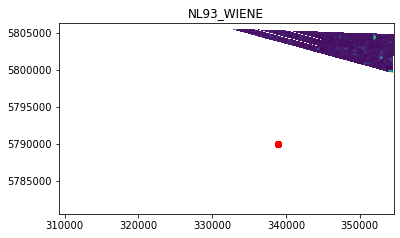

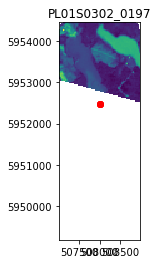

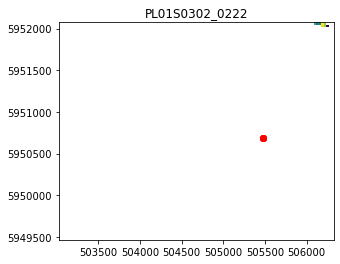

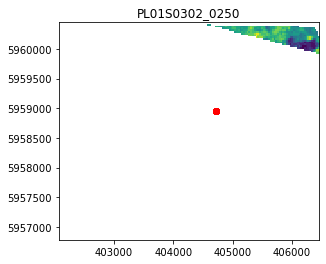

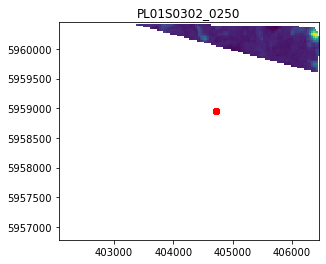

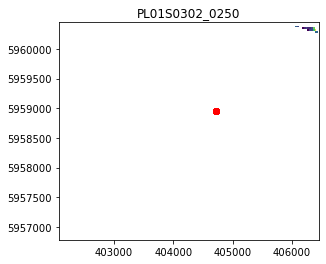

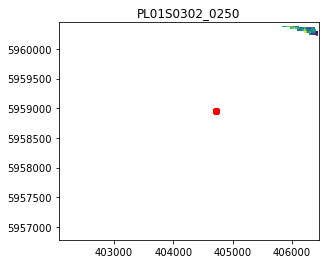

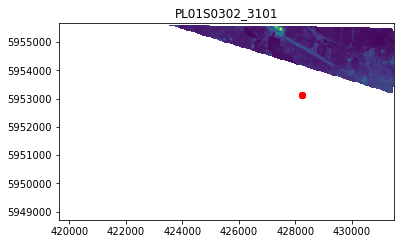

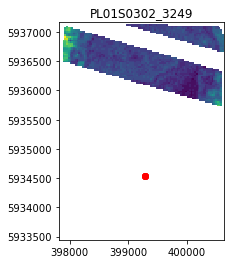

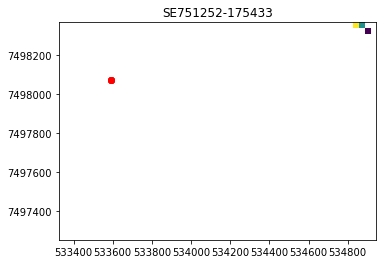

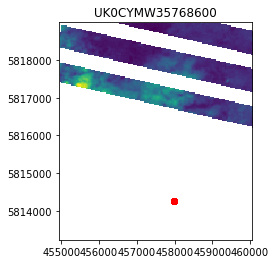

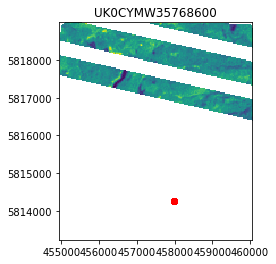

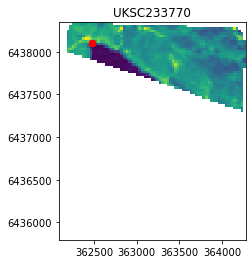

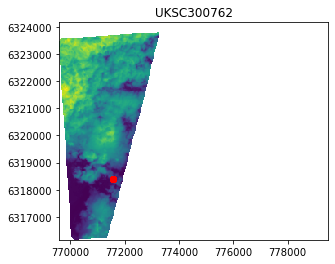

In [142]:
x= temp[temp.naprop<0.33]

for i in track(range(0,len(x))):
    
    src_path = c1_path+x.iloc[i].sid+'__'+x.iloc[i].eid+'_B2.tif'
    
    with rio.open(src_path) as src:

        data = src.read(1)
        print(data.size)

        fig, ax = plt.subplots()
        
        show(src,ax=ax)
        
        y = sites.loc[x.iloc[i].sid][['wb_cat','geometry_ll','geometry_poly']]
        y = y.set_geometry('geometry_ll')
        y.to_crs(src.crs).plot(ax=ax,color='r')

        plt.title(x.iloc[i].sid)
    src.close()


In [144]:
temp.to_csv('sids_eids_prop_NA.csv')

### Check for bad striping in ALL data

In [19]:
list(sites)

['wb_cat',
 'determinand_id',
 'value',
 'lon',
 'lat',
 'geometry_ll',
 'checked',
 'l7_scene_n1d10c',
 'l8_scene_n1d10c',
 'l7_scene_id',
 'l7_scene_dt',
 'l8_scene_id',
 'l8_scene_dt',
 'l7_scene_n4d20c',
 'l8_scene_n4d20c',
 'geometry_poly']

In [98]:
temp = sites.reset_index[['sid',]]
temp.head(2)

sid                                       eid  \
0  ATSE20501000  LC08_L1TP_191028_20150412_20170410_01_T1   
1  ATSE20501000  LE07_L1TP_191027_20090825_20161220_01_T1   

                                                call  \
0  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
1  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   

                                   error  
0  missing value where TRUE/FALSE needed  
1                                   none

In [99]:
temp['naprop'] = pd.Series(dtype=np.float,index=temp.index)
for i in track(range(0,len(temp))):
    src_path = c1_path+temp.iloc[i].sid+'__'+temp.iloc[i].eid+'_B2.tif'
    
    try: 
        with rio.open(src_path) as src:

            data = src.read(1)
            temp.loc[i,'naprop'] = data[data>0].size/data.size
            #print(ratio)
    
        src.close()        
    except:
        print(f'source not found for {temp.iloc[i,:].sid}__{temp.iloc[i,:].eid}')
        
temp.head(5)

 [████████████████████████████████████████████████████████████] 3157/3157 [01:11<00:00, 0.02s/it]

source not found for FISW_734__LC08_L1TP_187018_20170811_20170824_01_T1
source not found for PL01S0202_0069__LE07_L1TP_190022_20141003_20161101_01_T1
source not found for PL01S0202_0069__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL01S0202_3357__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3320__LC08_L1TP_193023_20130826_20170502_01_T1
source not found for PL02S0102_3330__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3331__LE07_L1TP_191022_20140807_20161111_01_T1
source not found for PL02S0102_3351__LE07_L1TP_191022_20140807_20161111_01_T1


sid                                       eid  \
0  ATSE20501000  LC08_L1TP_191028_20150412_20170410_01_T1   
1  ATSE20501000  LE07_L1TP_191027_20090825_20161220_01_T1   
2  ATSE20501000  LE07_L1TP_191027_20120326_20161203_01_T1   
3  ATSE20501000  LE07_L1TP_191027_20120918_20161129_01_T1   
4  ATSE20501000  LE07_L1TP_191028_20111119_20161205_01_T1   

                                                call  \
0  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
1  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
2  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
3  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   
4  if, Lhaze[1] < 0, stop("Estimated Lhaze is < 0...   

                                   error    naprop  
0  missing value where TRUE/FALSE needed  0.932857  
1                                   none  0.055445  
2                                   none  0.045326  
3                                   none  0.008313  
4                                   none  0.779199

number of tifs with less than 50% complete data 210


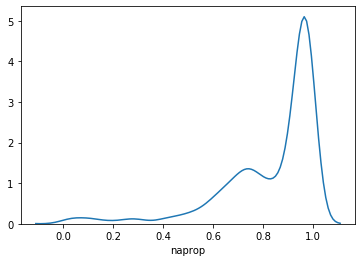

In [101]:
print(f'number of tifs with less than 50% complete data {len(temp[temp.naprop<0.5])}')
sn.distplot(temp.naprop,hist=False)

#### Plotting scenes

 [████████████████████████████████████████████████████████████] 130/130 [00:40<00:00, 0.30s/it]

53170
53170
53170
10380
97020
162176
38703
38703
204750
232104
34408
1077993
1032384
2870164
1118010
970898
1034180
59881
137740
137740
20590


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


316041


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


2624


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


514917


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


514917


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


525447


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


662337


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


66690


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47362


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47223


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


47223


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


5977


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


511200


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


474249


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


37950


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


358005


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


374465


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


390925


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


374465


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


382695


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


67392


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30072


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


8050


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


8050


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


9270


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


71380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91410


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91410


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


29380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


29380


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


30144


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


24964


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


24964


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


303601


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


303601


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11766


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


48208


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


298273


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


972000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


837000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


837000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1039500


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1081125


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1017000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1039500


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1062000


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1305068


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11375


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


9570


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


17812


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


91640


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


11656


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


1998


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


32832


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


32832


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


6205


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


88377


<ipython-input-142-0826d946b195>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


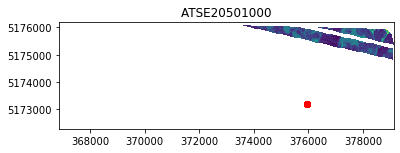

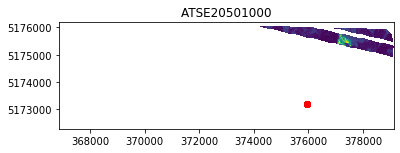

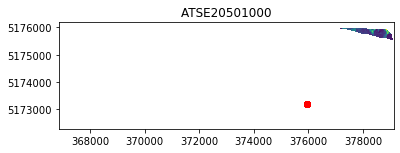

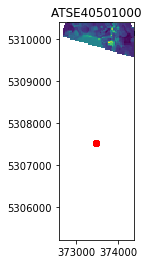

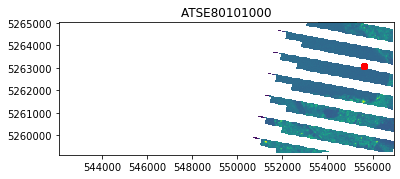

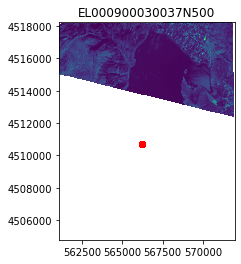

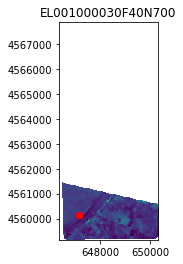

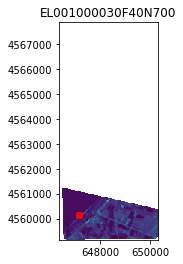

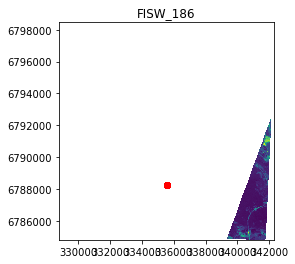

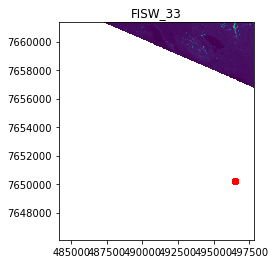

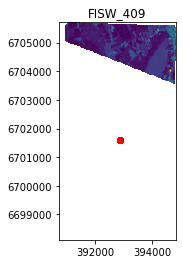

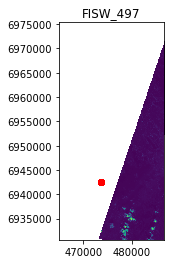

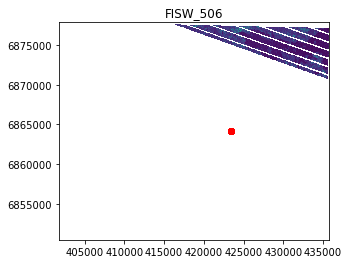

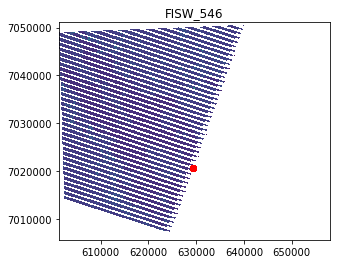

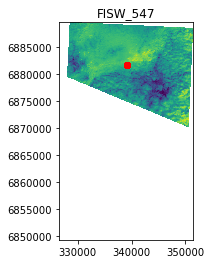

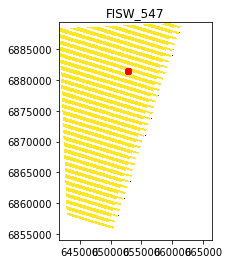

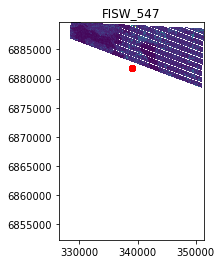

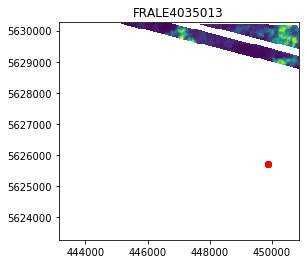

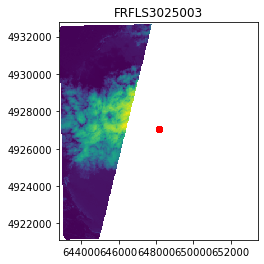

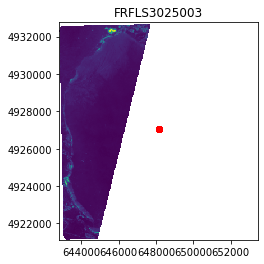

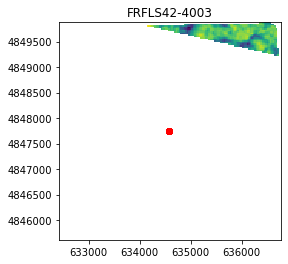

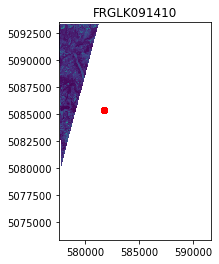

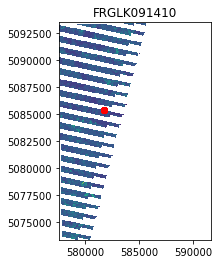

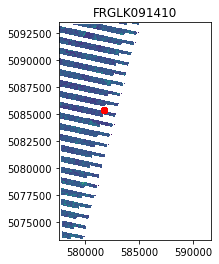

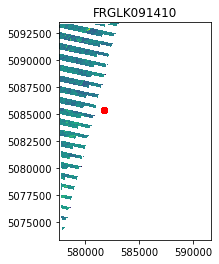

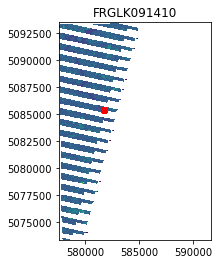

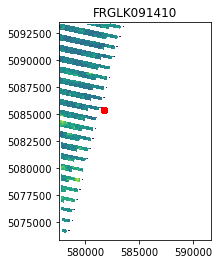

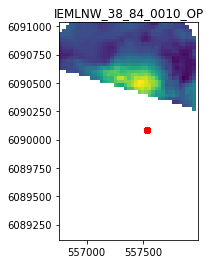

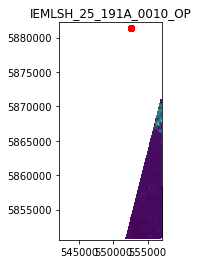

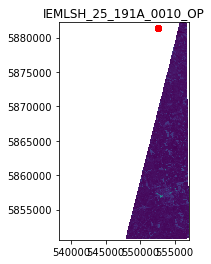

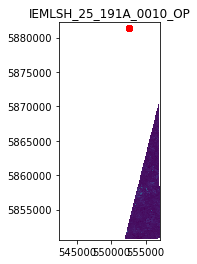

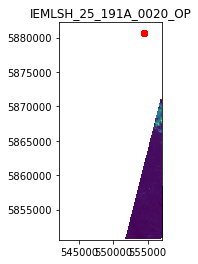

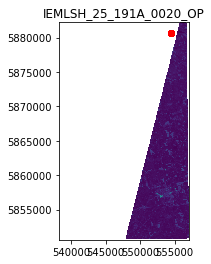

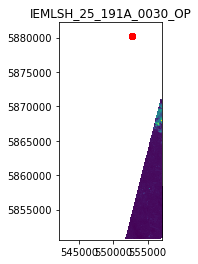

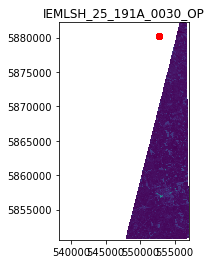

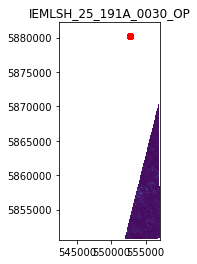

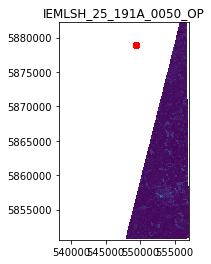

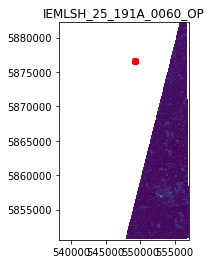

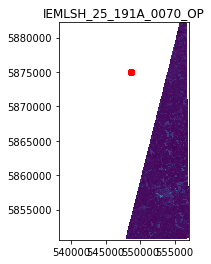

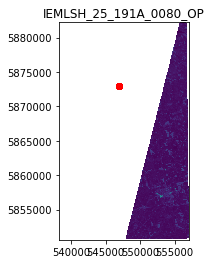

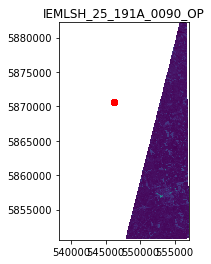

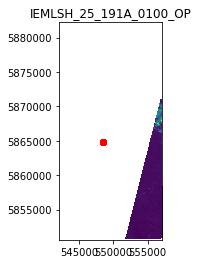

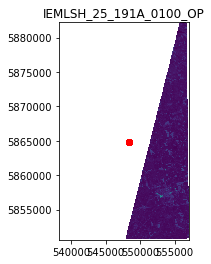

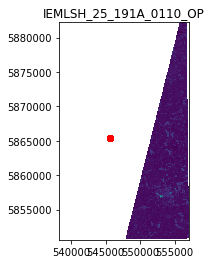

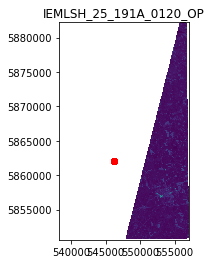

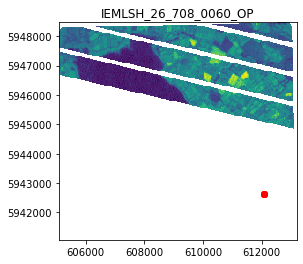

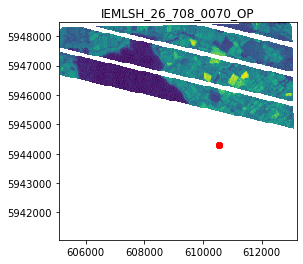

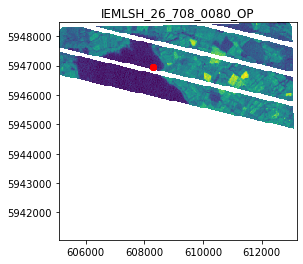

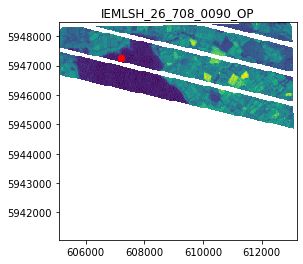

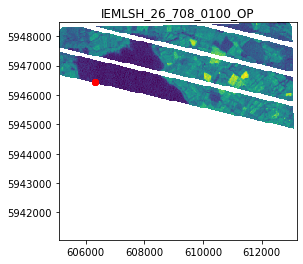

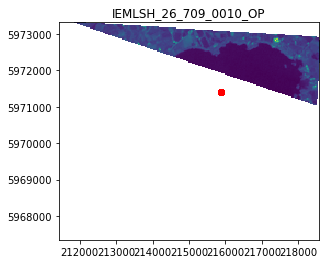

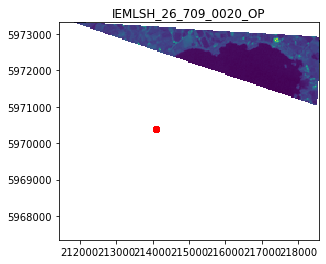

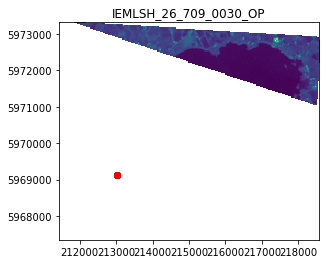

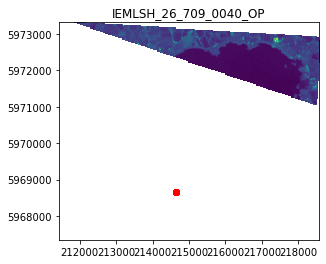

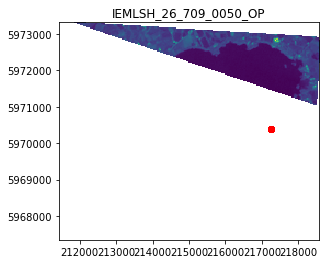

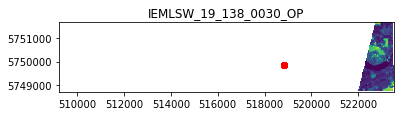

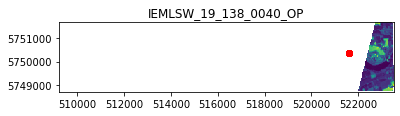

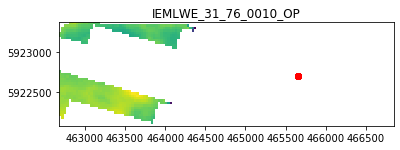

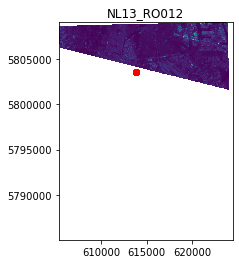

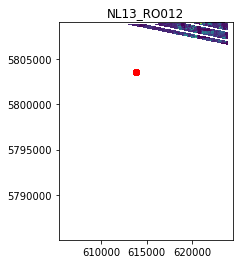

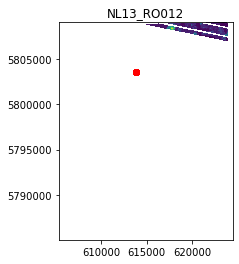

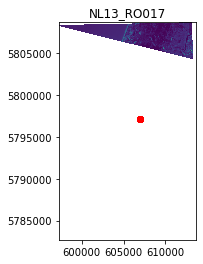

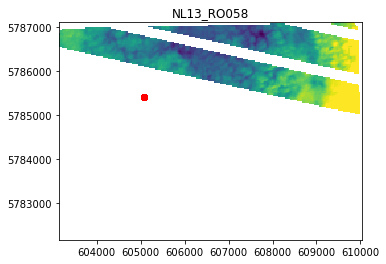

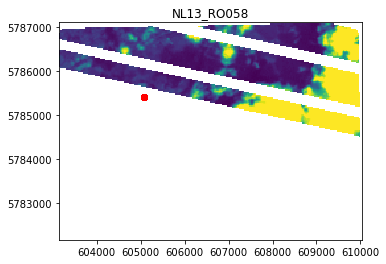

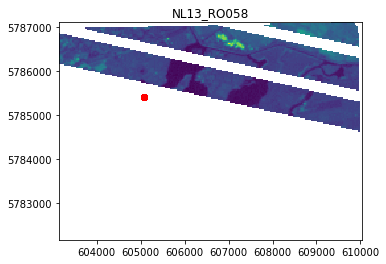

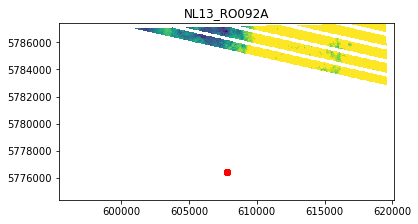

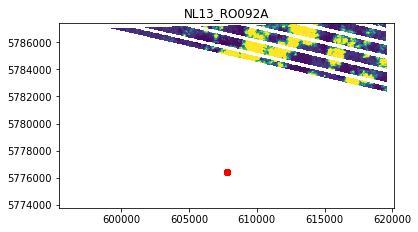

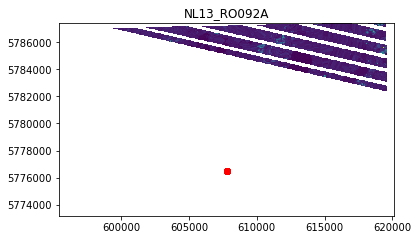

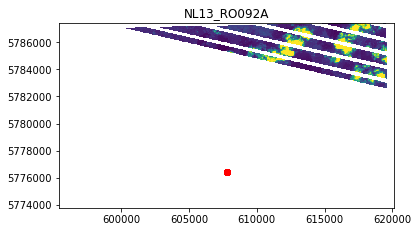

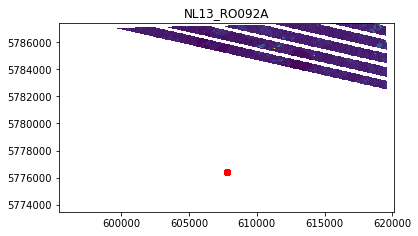

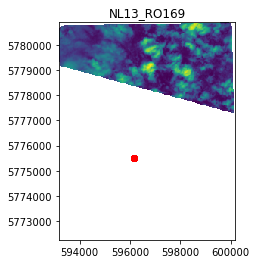

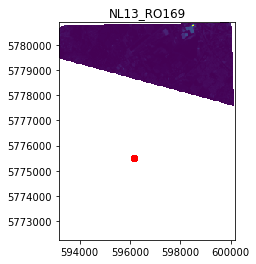

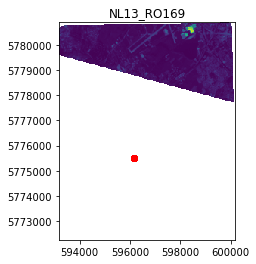

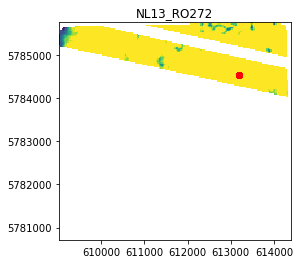

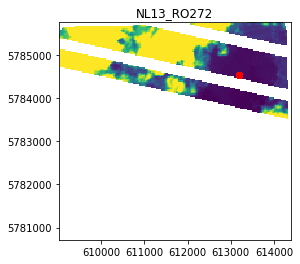

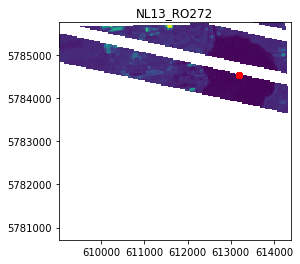

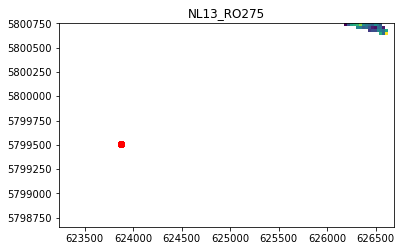

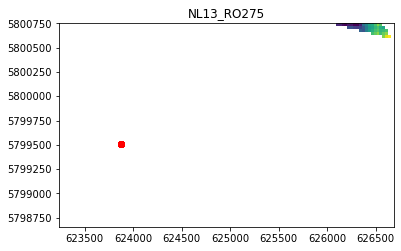

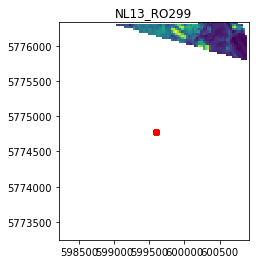

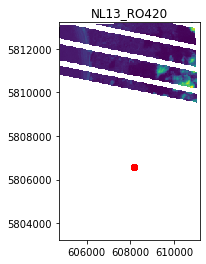

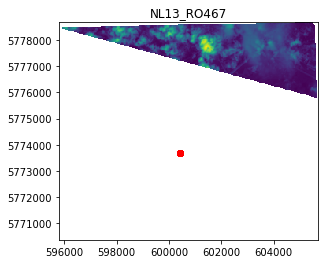

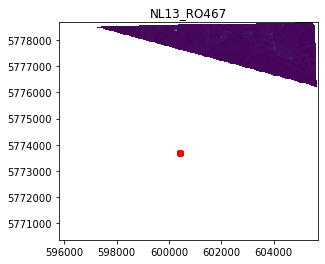

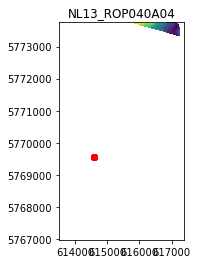

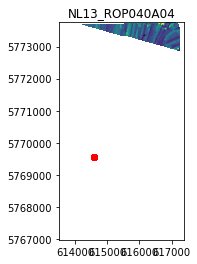

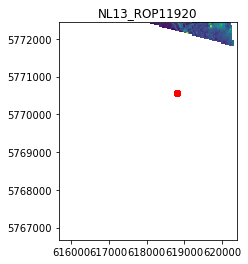

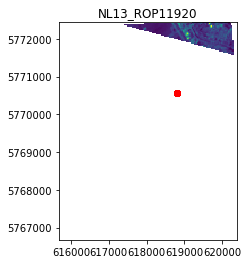

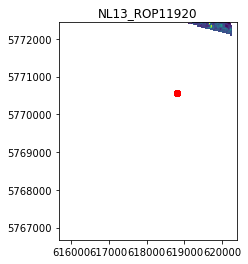

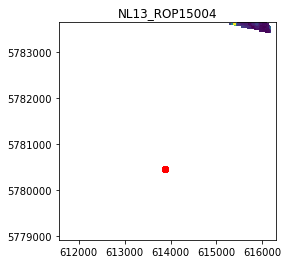

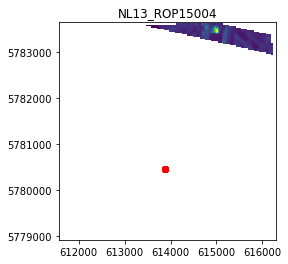

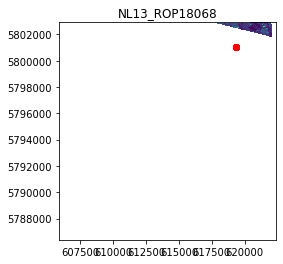

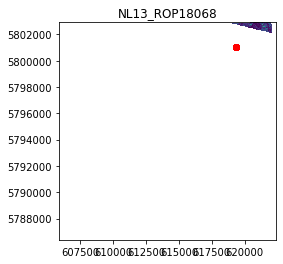

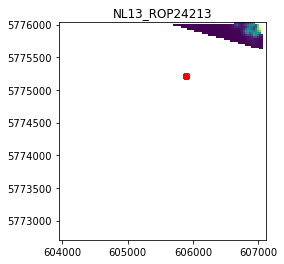

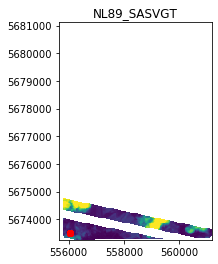

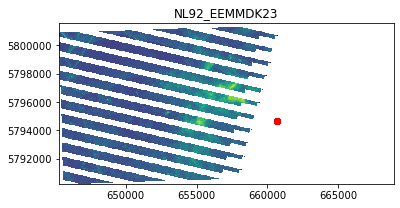

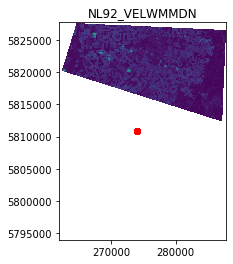

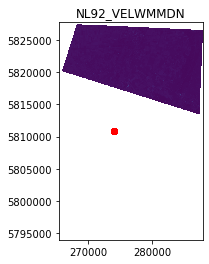

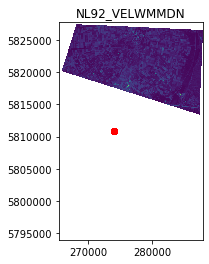

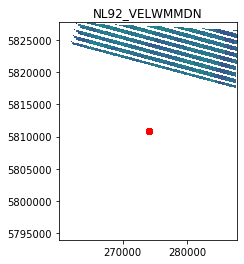

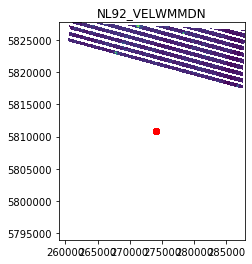

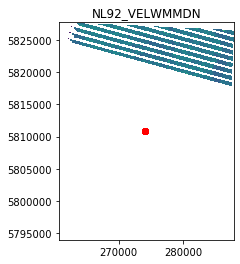

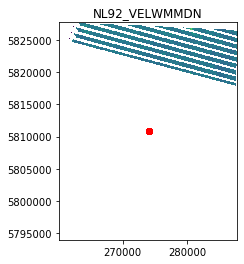

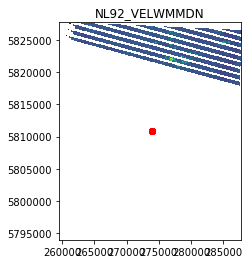

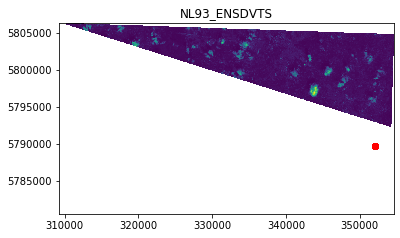

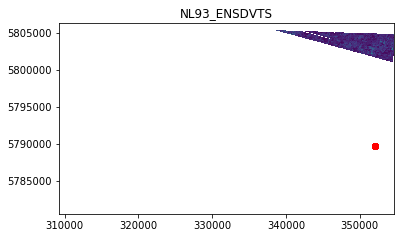

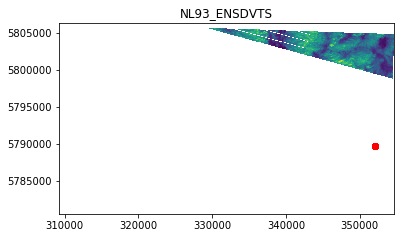

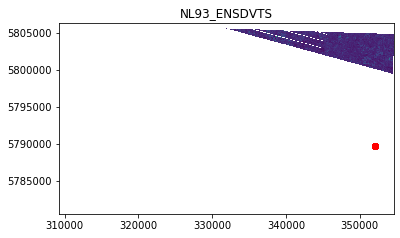

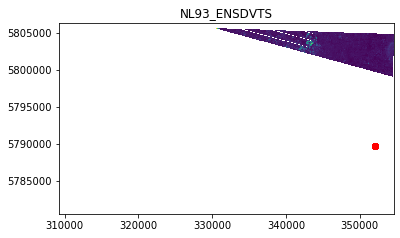

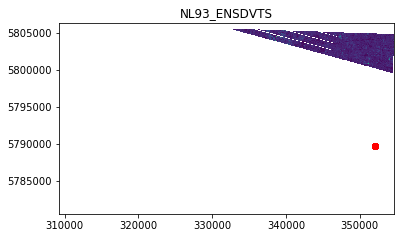

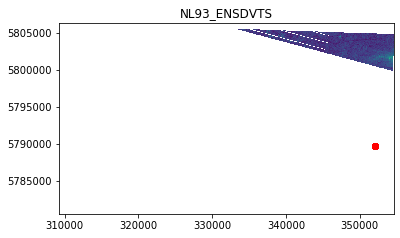

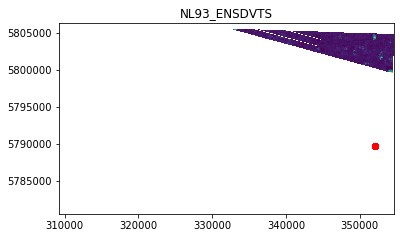

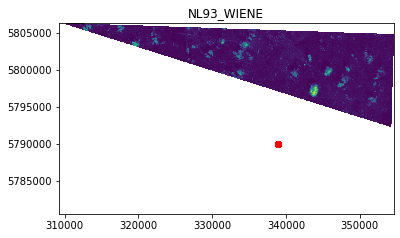

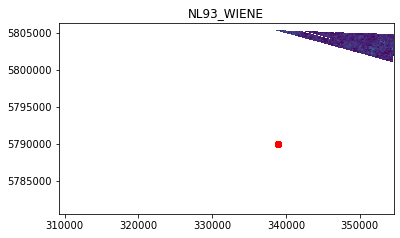

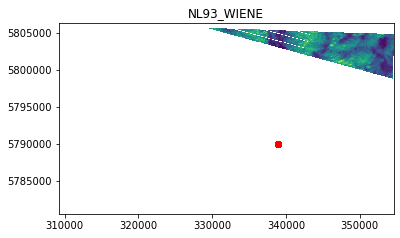

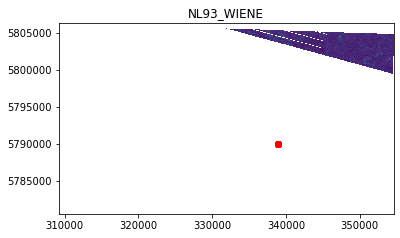

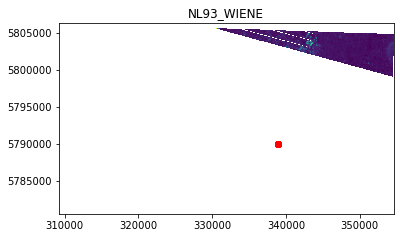

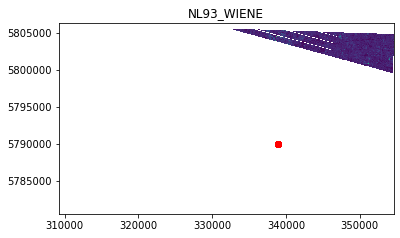

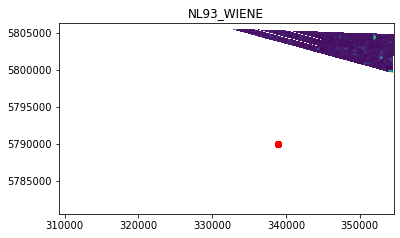

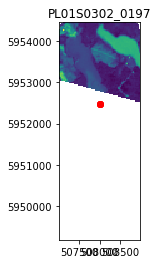

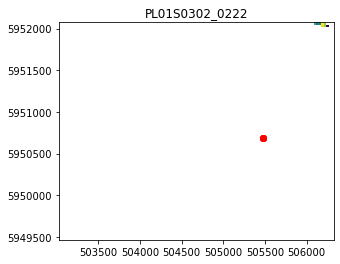

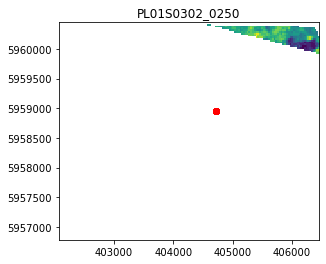

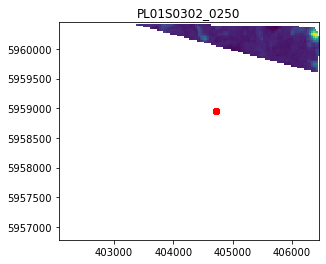

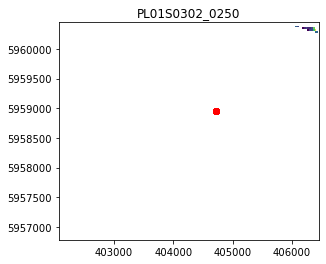

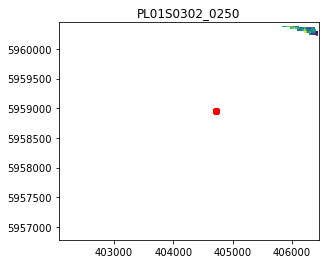

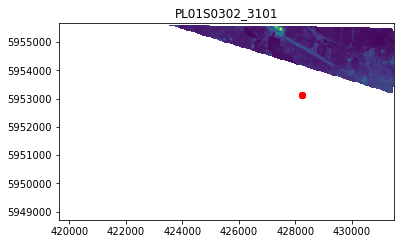

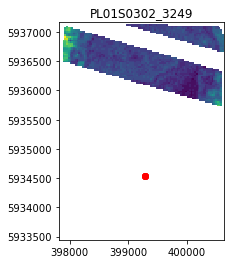

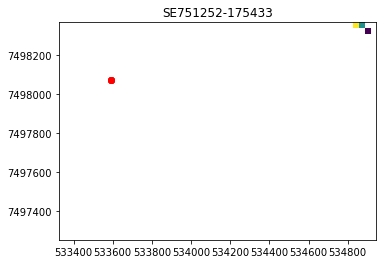

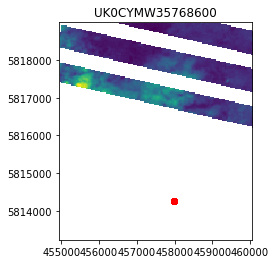

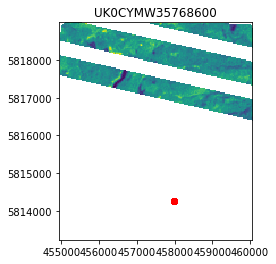

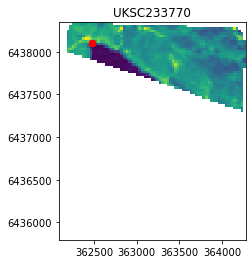

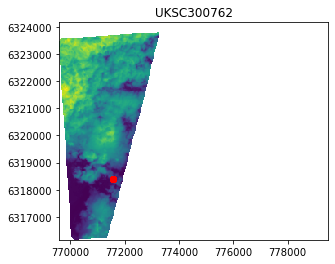

In [142]:
x= temp[temp.naprop<0.33]

for i in track(range(0,len(x))):
    
    src_path = c1_path+x.iloc[i].sid+'__'+x.iloc[i].eid+'_B2.tif'
    
    with rio.open(src_path) as src:

        data = src.read(1)
        print(data.size)

        fig, ax = plt.subplots()
        
        show(src,ax=ax)
        
        y = sites.loc[x.iloc[i].sid][['wb_cat','geometry_ll','geometry_poly']]
        y = y.set_geometry('geometry_ll')
        y.to_crs(src.crs).plot(ax=ax,color='r')

        plt.title(x.iloc[i].sid)
    src.close()


### Examining extracted pixels

 [████████████████████████████████████████████████████████████] 20/20 [00:06<00:00, 0.31s/it]

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis,

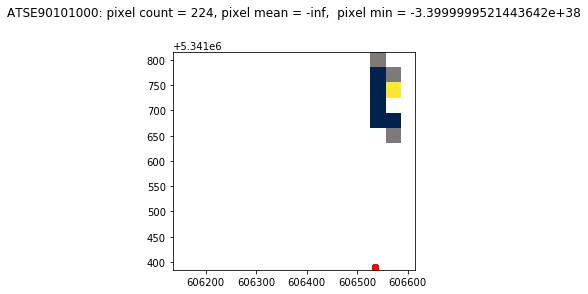

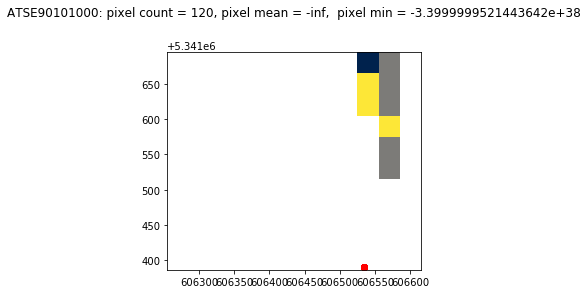

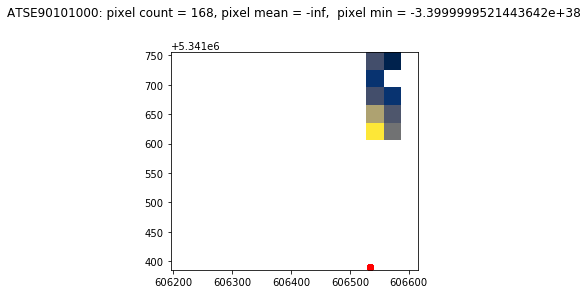

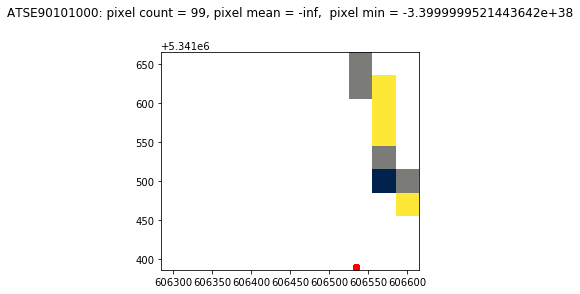

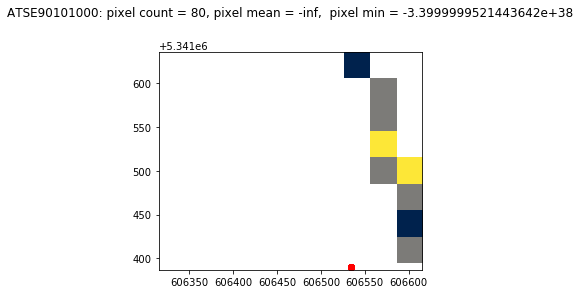

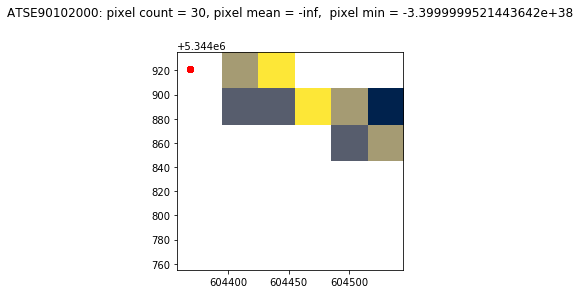

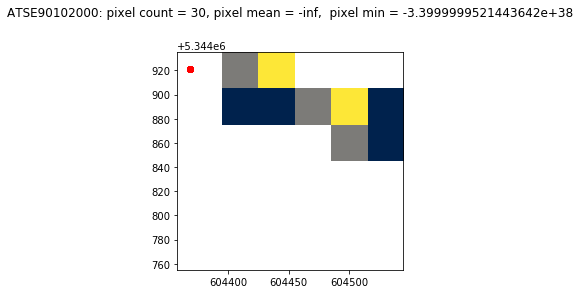

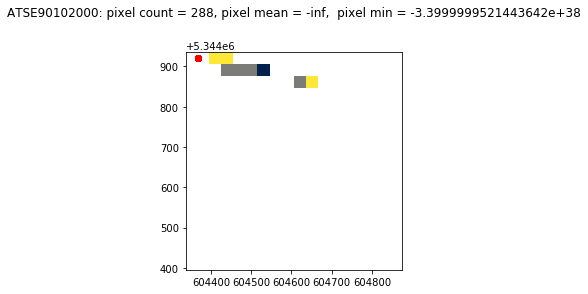

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


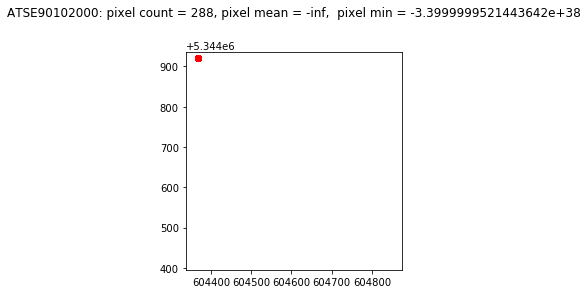

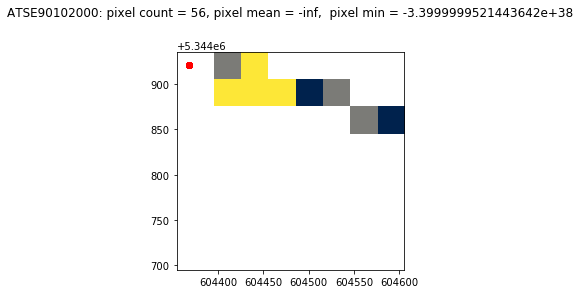

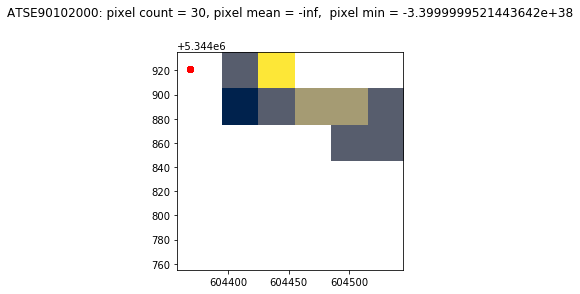

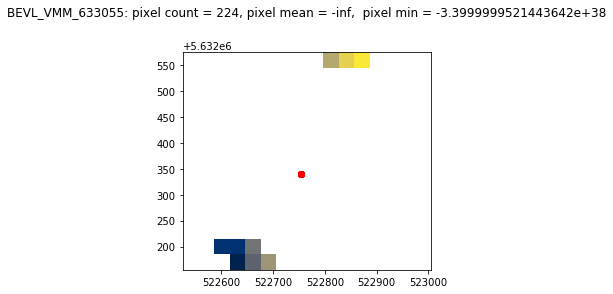

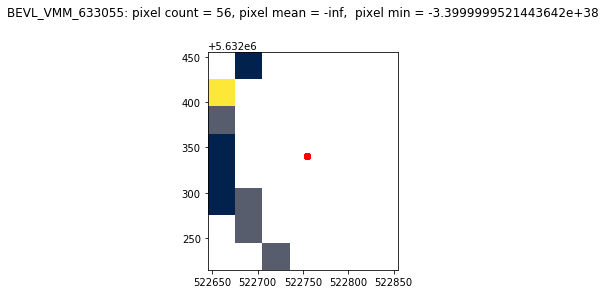

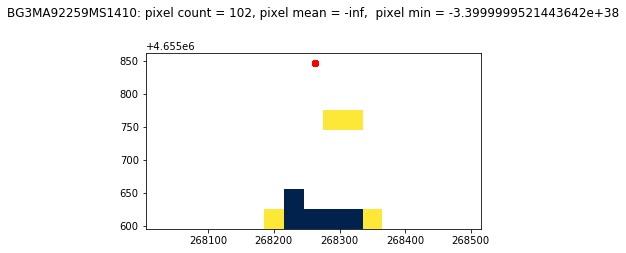

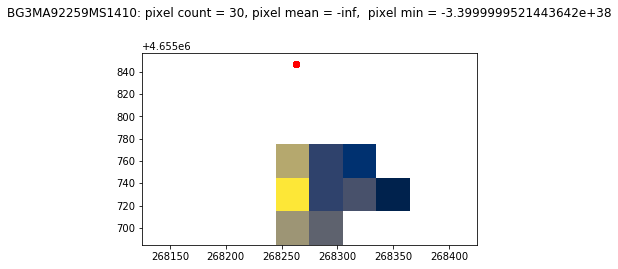

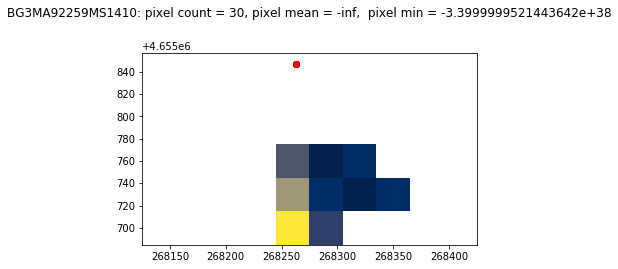

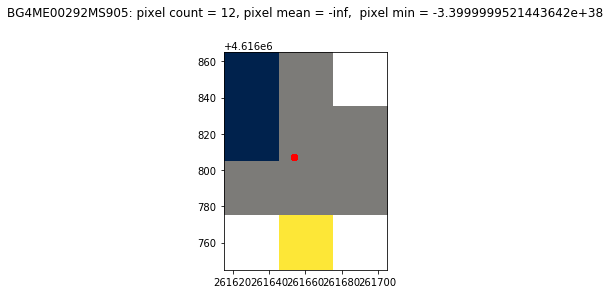

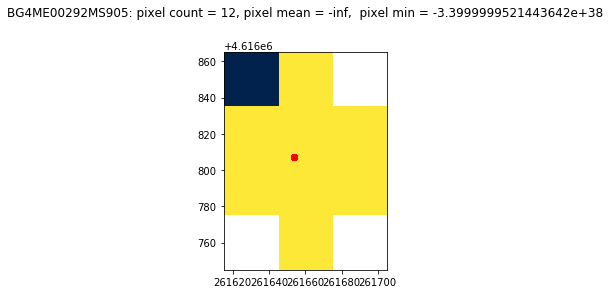

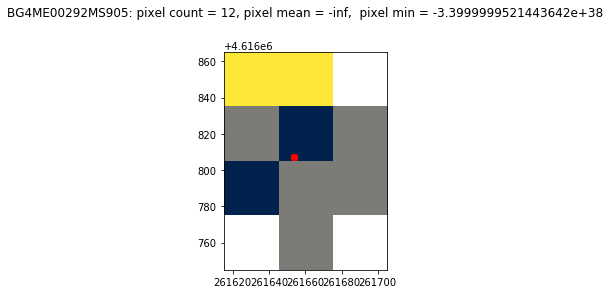

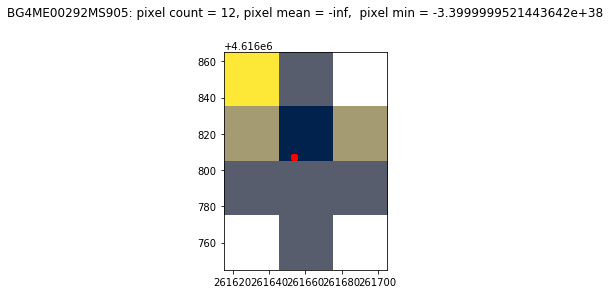

In [36]:
pix_path = "C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Pixels/"

pix = cor_files = os.listdir(pix_path)

pixsb2 = [ i for i in pix if 'B2' in i]

for pix in track(pixsb2[100:120]):
    
    src_path = pix_path+pix
    
    sid = pix.split('__')[0]
    
    with rio.open(src_path) as src:

        data = src.read(1)
        #print(data.size)

        fig, ax = plt.subplots()
        
        show(src,ax=ax,cmap='cividis')
        
        y = sites.loc[sid][['wb_cat','geometry_ll','geometry_poly']]
        y = y.set_geometry('geometry_ll')
        y.to_crs(src.crs).plot(ax=ax,color='r')

        plt.title(f'{sid}: pixel count = {data.size}, pixel mean = {data.mean()},  pixel min = {data.min()}\n\n' )
    src.close()

In [26]:
pix.split('__')[0]

'ATSE20101000'

### Checking out NL site


In [ ]:
sites = sites.set_geometry('geometry_poly')

nlsite = sites.loc['NL90_NEDWT']

fig, ax = plt.subplots()
nlsite.plot(ax=ax)
nlsite.set_geometry('geometry_ll').plot(ax=ax,color='r')

### Pixel extraction QA

In [10]:
os.chdir("C:/Users/User/Documents/Work/SDGs and AI/6.3.2")

sites = pd.read_pickle("sites2.p")
sites = sites.reset_index().set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')
sites = sites.drop(columns=['monitoringSiteIdentifier','wbid','thematicId'])

In [3]:
pl = sites[(sites['l8_scene_id'].notna())|(sites['l7_scene_id'].notna())]
pl = pl[pl.geometry_poly.notna()]

### Checking for duplicates in folder

In [23]:
files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Cropped level 1 data/")

files_nd = list(set(files))
len(files),len(files_nd)

(37339, 37339)

### Xarray construction

In [11]:
import rioxarray as xrio
import xarray as xr
import xshape as xs
from dea_spatialtools import xr_rasterize

import imageio
from ipypb import track
from IPython.display import Image
from scipy import spatial

In [12]:
os.chdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Corrected data V2")

## list of files to process
dl_files = os.listdir()

## list of files already processed
pixel_files = os.listdir("C:/Users/User/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Test/")

#for sid in track(pl.index.get_level_values(0).unique()):

sid = 'IEMLSH_26_708_0060_OP'
    
sid_files = [ i for i in dl_files if sid in i ]

eids = list(set([ i.split('__')[1][0:40] for i in sid_files ]))

eid = eids[0]

sid_eid_files = [ i for i in sid_files if eid in i ]


In [13]:
## get CRS of raster
with rio.open(sid_eid_files[0]) as src:            

    ras_crs = src.crs

src.close()

## read in first tif in list
xtif = xrio.open_rasterio(sid_eid_files[0],
                          masked=True,
                         default_name=sid_eid_files[0].split('__')[1][41:47].split('_')[0].replace('.',''))
xtif = xtif.load()
xtif = xtif[0]
xtif = np.round(xtif,5)
xtif['eid'] = sid_eid_files[0].split('__')[1][0:40]
xtif['sid'] = sid_eid_files[0].split('__')[0]



## add other tifs in a loop
for adtif in sid_eid_files[1:len(sid_eid_files)]:
    
    ## read in subsequent tifs and merge
    ytif = xrio.open_rasterio(adtif,
                              masked=True,
                              default_name=adtif.split('__')[1][41:47].split('_')[0].replace('.',''))
    ytif = ytif.load()
    ytif = ytif[0]
    ytif = np.round(ytif,5)
    xtif = xr.merge([xtif,ytif],compat='override')
    

## retrieve monitoring location as point
pt = sites.loc[sid,:].set_geometry('geometry_ll')[0:1]             

## change crs of pt
original_crs = sites.crs
pt = pt.to_crs(ras_crs)

## change crs of poly
poly = pt.set_geometry('geometry_poly')
poly.crs = original_crs
poly = poly.to_crs(ras_crs) 
    
## Add polygon and point to xarray
# xpt = xr.DataArray(1, coords=[np.array([1]), 
#                               pt.geometry.values.y, 
#                               pt.geometry.values.x], 
#                    dims=['band','y', 'x'],
#                    name='monitor_pt')

# xtif = xr.merge([xtif,xpt],compat='override')

## Add attributes to combined xarray from last tif
xtif.attrs = {key: ytif.attrs[key] for key in ytif.attrs.keys() & {'transform', 'scale_factor','add_offset','grid_mapping'}}
xtif.attrs['shape'] = xtif['B2'].shape
xtif.attrs['crs'] = str(src.crs)

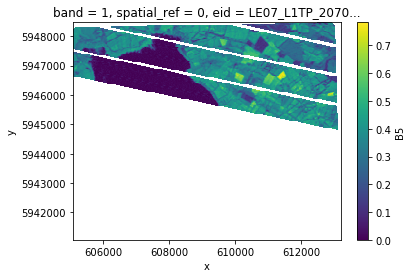

In [14]:
fig, ax = plt.subplots()
xtif['B5'].plot(ax=ax)
#xtif['monitor_pt'].plot(ax=ax,cmap='OrRd')

#### Rasterize polygon

Rasterizing to match xarray.DataArray dimensions (75, 93) and projection system/CRS (e.g. EPSG:32631)


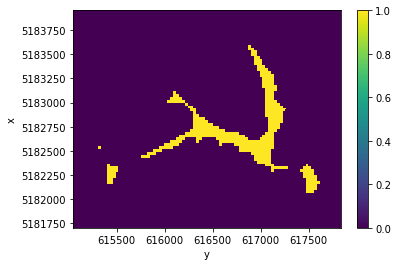

In [977]:
mask = xr_rasterize(poly.buffer(-50), xtif)
mask.plot()

#### Create mask as xarray object

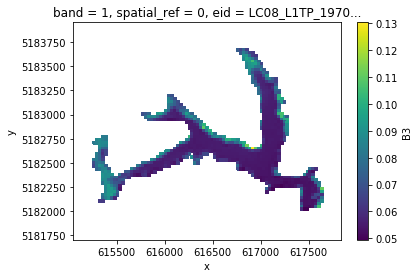

In [695]:
## Create mask
ShapeMask = rasterio.features.geometry_mask(poly.geometry,
                                      out_shape=(len(xtif.y), len(xtif.x)),
                                      transform=xtif.geobox.transform,
                                      invert=True)

ShapeMask = xr.DataArray(ShapeMask, dims=("y", "x"))

## Then apply the mask
xtif_masked = xtif.where(ShapeMask == True)

fig, ax = plt.subplots()
xtif_masked['B3'].plot(ax=ax)
#xtif_masked['monitor_pt'].plot(ax=ax,cmap='OrRd')

### Selecting pixels

In [87]:
## select after storing point in xarray - DOESN'T WORK

xtif2 = xtif.drop_vars('monitor_pt',errors = 'raise').reset_coords(['x','y']).set_coords(['x','y'])

x = xtif['monitor_pt'].where(xtif['monitor_pt'] > 0,drop=True).x.values[0]
y = xtif['monitor_pt'].where(xtif['monitor_pt'] > 0,drop=True).y.values[0]

test = xtif2.sel(x=x,y=y, method='nearest',)
test['B2'].values

array([nan])

In [21]:
k=9

# Create list of coordinates
x = list(xtif.x.values)
y = list(xtif.y.values)

coords = np.array(list(zip(sorted(y*len(x),reverse=True),sorted(x)*len(y))))

## create point from shapefile
ptxy = np.array([pt.geometry.y.values[0],pt.geometry.x.values[0]])

## construct KD-tree
tree = spatial.cKDTree(coords)

## query tree for n nearest neighbours
yx, index = tree.query(ptxy,k=k)
print(f'Index return from tree query for k={k}: {index}')

## Change back to 2D grid
indexf = np.unravel_index(index, xtif.shape)
print(f'\nIndex returned after transformation to 2D: {indexf}')

## Create xarray index object
# xr_index = xr.DataArray(indexf[0], dims='y'), \
#                xr.DataArray(indexf[1], dims='x')

Index return from tree query for k=9: [52882 52612 52883 52613 52881 53152 52611 53153 52342]

Index returned after transformation to 2D: (array([195, 194, 195, 194, 195, 196, 194, 196, 193], dtype=int64), array([232, 232, 233, 233, 231, 232, 231, 233, 232], dtype=int64))


In [22]:
indexf

array([52882, 52612, 52883, 52613, 52881, 53152, 52611, 53153, 52342])

In [697]:
## select pixels from xarray using isel

y_index = indexf[0]
x_index = indexf[1]

pixels = xtif.isel(y=y_index,x=x_index)

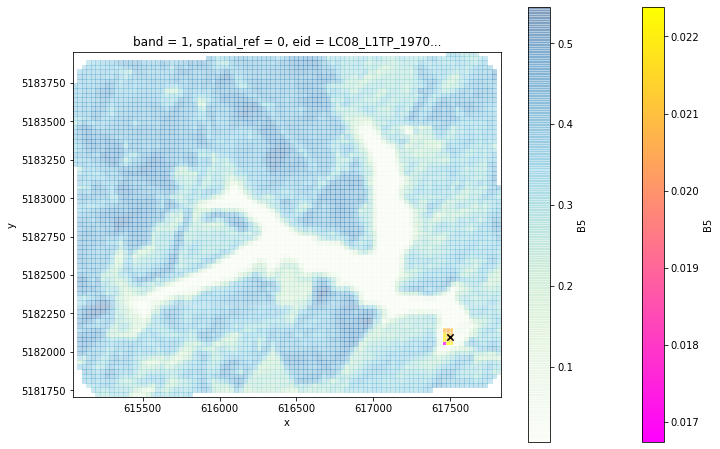

In [698]:
fig, ax = plt.subplots(figsize=(12,8))

pixels.sortby(['x','y'])['B5'].plot(cmap='spring',ax=ax)
xtif['B5'].plot(alpha=0.3,ax=ax,cmap='GnBu')
pt.plot(ax=ax,color='k',marker='x',markersize=40)

In [703]:
pixels['B5'].shape, xtif['B5'].shape

((9, 9), (75, 93))

In [723]:
np.mean(pixels.B2),np.var(pixels.B2)

(<xarray.DataArray 'B2' ()>
 array(0.08252743)
 Coordinates:
     band         int32 1
     spatial_ref  int32 0
     eid          <U40 'LC08_L1TP_197027_20130923_20170502_01_T1'
     sid          <U12 'FRDLU3005023',
 <xarray.DataArray 'B2' ()>
 array(1.26167788e-07)
 Coordinates:
     band         int32 1
     spatial_ref  int32 0
     eid          <U40 'LC08_L1TP_197027_20130923_20170502_01_T1'
     sid          <U12 'FRDLU3005023')

In [726]:
pickle.dump(xtif,open("C:/Users/User/Documents/Work/SDGs and AI/6.3.2/xtif.pkl","wb"),-1)
pickle.dump(pt,open("C:/Users/User/Documents/Work/SDGs and AI/6.3.2/pt.pkl","wb"))

### Pixel selection using euclidean distance

In [15]:
X = np.tile(xtif.x.values,(len(xtif.y.values),1))
Y = np.tile(xtif.y.values,(len(xtif.x.values),1))

x, y = X.flatten(), Y.flatten()

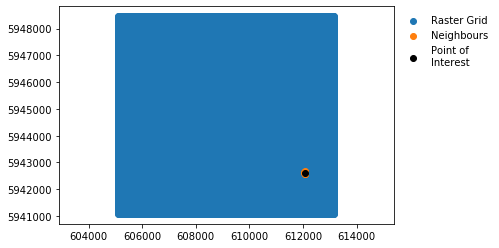

In [16]:
k = 9

PoI = (pt.geometry.x.values[0],pt.geometry.y.values[0])

x_dist = np.abs(x - PoI[0])
y_dist = np.abs(y - PoI[1])

euc_dist = np.sqrt(x_dist**2 + y_dist**2)
max_neighbour_dist = sorted(euc_dist)[k]

neighbours_x = x[euc_dist<max_neighbour_dist]
neighbours_y = y[euc_dist<max_neighbour_dist]

## Plotting

fig, ax = plt.subplots()

ax.scatter(x, y, label='Raster Grid')
ax.scatter(neighbours_x, neighbours_y, label='Neighbours')
ax.scatter(*PoI, color='k', label='Point of\nInterest')
ax.axis('equal')
#ax.set_xlim(617000,617800)

ax.legend(frameon=False, bbox_to_anchor=(1, 1))

In [17]:
pixels = xtif.sel(x=neighbours_x,y=neighbours_y,drop=True)

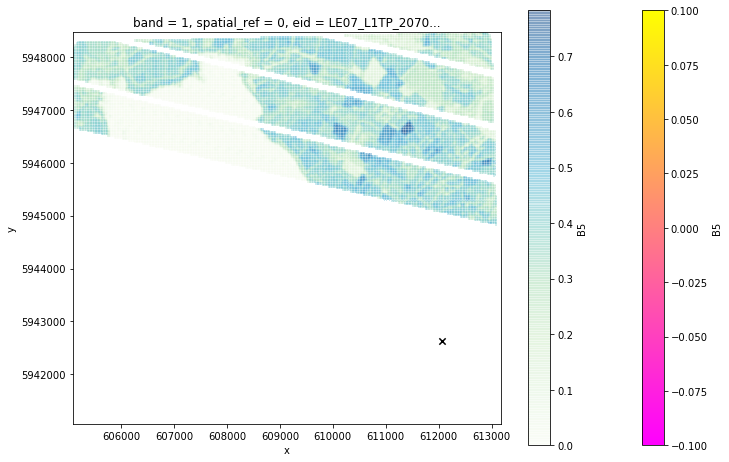

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

pixels.sortby(['x','y'])['B5'].plot(cmap='spring',ax=ax)
xtif['B5'].plot(alpha=0.3,ax=ax,cmap='GnBu')
pt.plot(ax=ax,color='k',marker='x',markersize=40)

In [19]:
pixels['B5']

<xarray.DataArray 'B5' (y: 9, x: 9)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
    band         int32 1
  * y            (y) float64 5.943e+06 5.943e+06 ... 5.943e+06 5.943e+06
  * x            (x) float64 6.121e+05 6.121e+05 ... 6.12e+05 6.121e+05
    spatial_ref  int32 0
    eid          <U40 'LE07_L1TP_207022_20151013_20161018_01_T1'
    sid          <U21 'IEMLSH_26_708_0060_OP'

In [983]:
pdf = pixels.to_dataframe()

In [985]:
pdf.reset_index().head(40)

x          y  band  spatial_ref  \
0   617520.0  5182110.0     1            0   
1   617520.0  5182080.0     1            0   
2   617520.0  5182050.0     1            0   
3   617520.0  5182110.0     1            0   
4   617520.0  5182080.0     1            0   
5   617520.0  5182050.0     1            0   
6   617520.0  5182110.0     1            0   
7   617520.0  5182080.0     1            0   
8   617520.0  5182050.0     1            0   
9   617460.0  5182110.0     1            0   
10  617460.0  5182080.0     1            0   
11  617460.0  5182050.0     1            0   
12  617460.0  5182110.0     1            0   
13  617460.0  5182080.0     1            0   
14  617460.0  5182050.0     1            0   
15  617460.0  5182110.0     1            0   
16  617460.0  5182080.0     1            0   
17  617460.0  5182050.0     1            0   
18  617490.0  5182110.0     1            0   
19  617490.0  5182080.0     1            0   
20  617490.0  5182050.0     1            0   
21  617490.0  5182110.0     1            0   
22  617490.0  5182080.0     1            0   
23  617490.0  5182050.0     1            0   
24  617490.0  5182110.0     1            0   
25  617490.0  5182080.0     1            0   
26  617490.0  5182050.0     1            0   
27  617520.0  5182110.0     1            0   
28  617520.0  5182080.0     1            0   
29  617520.0  5182050.0     1            0   
30  617520.0  5182110.0     1            0   
31  617520.0  5182080.0     1            0   
32  617520.0  5182050.0     1            0   
33  617520.0  5182110.0     1            0   
34  617520.0  5182080.0     1            0   
35  617520.0  5182050.0     1            0   
36  617460.0  5182110.0     1            0   
37  617460.0  5182080.0     1            0   
38  617460.0  5182050.0     1            0   
39  617460.0  5182110.0     1            0   

                                         eid           sid        B10  \
0   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.83646   
1   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.81131   
2   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.75845   
3   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.83646   
4   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.81131   
5   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.75845   
6   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.83646   
7   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.81131   
8   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.75845   
9   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.56699   
10  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.52411   
11  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.46100   
12  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.56699   
13  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.52411   
14  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.46100   
15  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.56699   
16  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.52411   
17  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.46100   
18  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.61740   
19  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.59470   
20  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.55688   
21  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.61740   
22  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.59470   
23  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.55688   
24  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.61740   
25  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.59470   
26  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.55688   
27  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.83646   
28  LC0

In [989]:
pdf.reset_index().drop_duplicates()

x          y  band  spatial_ref  \
0   617520.0  5182110.0     1            0   
1   617520.0  5182080.0     1            0   
2   617520.0  5182050.0     1            0   
9   617460.0  5182110.0     1            0   
10  617460.0  5182080.0     1            0   
11  617460.0  5182050.0     1            0   
18  617490.0  5182110.0     1            0   
19  617490.0  5182080.0     1            0   
20  617490.0  5182050.0     1            0   

                                         eid           sid        B10  \
0   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.83646   
1   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.81131   
2   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.75845   
9   LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.56699   
10  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.52411   
11  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.46100   
18  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.61740   
19  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.59470   
20  LC08_L1TP_197027_20130923_20170502_01_T1  FRDLU3005023  291.55688   

          B11       B2       B3       B4       B5  cirrus  cloud  
0   290.52106  0.08263  0.05331  0.03558  0.02059     1.0    1.0  
1   290.48856  0.08321  0.05327  0.03561  0.02103     1.0    1.0  
2   290.38513  0.08229  0.05139  0.03327  0.02198     1.0    1.0  
9   290.34967  0.08296  0.05321  0.03512  0.02177     1.0    1.0  
10  290.30530  0.08204  0.05321  0.03567  0.02201     1.0    1.0  
11  290.23724  0.08256  0.05290  0.03512  0.01674     1.0    1.0  
18  290.38217  0.08235  0.05306  0.03493  0.02115     1.0    1.0  
19  290.34671  0.08235  0.05309  0.03552  0.02103     1.0    1.0  
20  290.26389  0.08210  0.05232  0.03465  0.02238     1.0    1.0

### Size of downloaded images

In [ ]:
df = sites[sites.display_id.notna()].reset_index().groupby('display_id').count()

df.sid.mean()*950*9.5

path = "E:/University College London/O'Sullivan, Aidan - SDG6/Landsat data/Cropped level 1 data"

os.chdir(path)

sum(os.path.getsize(f) for f in os.listdir() if os.path.isfile(f))

### Plotting tdelt on matched scenes

In [ ]:
fig, ax = plt.subplots()

sn.distplot(sites.tdelta,kde=False,bins=8,
           hist_kws={ "linewidth": 1,
                            "alpha": 0.75, "color": "purple","fill":'purple',"rwidth":0.97},ax=ax)
ax.set_xlabel('Time delta (days)')

### Addressing site UoM

In [146]:
sites_data_neea = pd.read_csv('./In situ data/non_eea_site_data.csv')
sites = pd.read_pickle("sites3.p")

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
sites_data_neea[['resultObservedValue','resultUom']].groupby('resultUom').describe()

resultObservedValue                                            \
                        count       mean         std       min      25%   
resultUom                                                                 
#/l                     306.0  42.297458  279.347502   0.00000  3.62500   
IVFU                     68.0  28.785294   39.488409   0.30000  2.07500   
None                      1.0   0.000000         NaN   0.00000  0.00000   
RFU                    1009.0   2.458365    2.485860   0.00000  1.40000   
mg                        5.0  66.540000  140.850286   3.10000  3.50000   
mg/cm3                    1.0   2.100000         NaN   2.10000  2.10000   
mg/l                   4080.0   2.153812   23.758796   0.00000  0.00400   
mg/m2                    57.0   9.498246   21.392351   0.10000  0.20000   
mg/m3                 51386.0  25.653486   44.949520 -19.98940  3.30000   
ppb                    4779.0  29.642701  369.921597   0.00000  2.40000   
ppm                     486.0  19.346091   26.180278   0.56000  4.78250   
ug/L                   1328.0  29.111323   39.975022   0.00000  0.00330   
ug/cm2                    6.0   0.001692    0.001351   0.00065  0.00084   
ug/l                 283426.0  24.457388  822.148914  -6.00000  2.69000   

                                             
                 50%      75%           max  
resultUom                                    
#/l         9.200000  26.0000    4581.90000  
IVFU        7.950000  36.9500     170.00000  
None        0.000000   0.0000       0.00000  
RFU         2.100000   2.8000      22.70000  
mg          3.600000   4.0000     318.50000  
mg/cm3      2.100000   2.1000       2.10000  
mg/l        0.010315   0.0340    1248.00000  
mg/m2       0.400000   2.1000     104.00000  
mg/m3      11.000000  29.8000    3980.00000  
ppb         4.200000  18.8895   24856.03000  
ppm         9.690000  22.1275     200.53000  
ug/L       17.500000  49.0000     504.00000  
ug/cm2      0.001275   0.0018       0.00428  
ug/l        6.500000  19.0000  187000.00000

### Looking for duplicates

#### Checking duplicates in site ids when split

In [26]:
neea_sids = sites_data_neea.monitoringSiteIdentifier.drop_duplicates()

In [27]:
neea_sids2 = list(set([ i.split('-')[1] if len(i.split('-'))>1 else i for i in neea_sids]))

In [28]:
len(neea_sids),len(neea_sids2)

(15660, 9062)

In [37]:
sites_data_neea['sid2'] = [ i.split('-')[1] if len(i.split('-'))>1 else i for i in sites_data_neea.monitoringSiteIdentifier]
sites_data_neea.head(3)

Source                                 metadata_versionId  \
0    EAE  http://environment.data.gov.uk/water-quality/d...   
1    EAE  http://environment.data.gov.uk/water-quality/d...   
2    EAE  http://environment.data.gov.uk/water-quality/d...   

  monitoringSiteIdentifier                    waterBodyIdentifier  \
0              NE-44100119  TUNSTALL RESERVOIR NEAR DAM WALL WEST   
1              NE-44100119  TUNSTALL RESERVOIR NEAR DAM WALL WEST   
2              NE-44100119  TUNSTALL RESERVOIR NEAR DAM WALL WEST   

      parameterWaterBodyCategory phenomenonTimeSamplingDate  \
0  POND / LAKE / RESERVOIR WATER       2000-02-09T10:20:00Z   
1  POND / LAKE / RESERVOIR WATER       2000-02-25T11:10:00Z   
2  POND / LAKE / RESERVOIR WATER       2000-03-20T10:45:00Z   

  determinandDefinition observedPropertyDeterminandCode  resultObservedValue  \
0         Chlorophyll a                            0729                 0.50   
1         Chlorophyll a                            0729                 0.90   
2         Chlorophyll a                            0729                 3.09   

  resultUom       lon        lat Country      sid2  
0      ug/l -1.902405  54.762447      UK  44100119  
1      ug/l -1.902405  54.762447      UK  44100119  
2      ug/l -1.902405  54.762447      UK  44100119

In [61]:
len(sites_data_neea)-len(sites_data_neea[['resultObservedValue','sid2','phenomenonTimeSamplingDate','lon','lat']].drop_duplicates())

25404

#### Splitting site id to check for duplicates in US data

In [147]:
sites['sid2'] = [ i.split('-')[1] if len(i.split('-'))>1 else i for i in sites.reset_index().sid]

In [150]:
duplicated_bool = sites.reset_index()[['value','sid2','obs_time','lon','lat']].duplicated()

f'Duplicated data point based on datetime, site id, lon-lat: {sum(duplicated_bool)}'

'Duplicated data point based on datetime, site id, lon-lat: 16138'

In [100]:
duplicated_bool2 = sites.reset_index()[['value','sid2','obs_time']].duplicated()

f'Duplicated data point based on datetime, site id without lon-lat: {sum(duplicated_bool2)}'

'Duplicated data point based on datetime, site id without lon-lat: 38684'

#### Checking if precision is the same for lat lon at single site

In [81]:
sites['lon_prec'] = [len(str(i)) for i in sites.lon ]

In [94]:
sid_prec = sites.groupby(['sid2','lon_prec'],as_index=False).count()

In [104]:
sid_prec[sid_prec.sid2.duplicated()].head(20)

sid2  lon_prec  source  wb_cat  determinand_id  value  lon  lat  \
1           000        18      15      15              15     15   15   15   
3           001         7      22      22              22     22   22   22   
6           003        18       5       5               5      5    5    5   
53   0208458892        12       1       1               1      1    1    1   
55   0208458893        12       1       1               1      1    1    1   
116    03080101        18       6       6               0      6    6    6   
118    03080102         9      97      97               0     97   97   97   
119    03080102        11      15      15               0     15   15   15   
120    03080102        18      45      45               0     45   45   45   
122    03090101         8      29      29               0     29   29   29   
123    03090101         9     266     266               0    266  266  266   
124    03090101        11     123     123               0    123  123  123   
125    03090101        18      62      62               0     62   62   62   
127    03100101         9      57      57               0     57   57   57   
128    03100101        11     118     118               0    118  118  118   
129    03100101        18      20      20               0     20   20   20   
131    03100208         9       4       4               0      4    4    4   
132    03100208        11       8       8               0      8    8    8   
134    03110201         9       6       6               0      6    6    6   
135    03110201        11      13      13               0     13   13   13   

     geometry_ll  checked  scene_id  aquisition_dt  scene_dt  obs_time  \
1             15       15         9              6         3        15   
3             22       22        12              7         5        22   
6              5        5         4              2         2         5   
53             1        1         0              0         1         1   
55             1        1         0              0         1         1   
116            6        6         0              0         1         6   
118           97       97         0              0        74        97   
119           15       15         0              0        13        15   
120           45       45         0              0        34        45   
122           29       29         0              0        23        29   
123          266      266         0              0       191       266   
124          123      123         0              0       104       123   
125           62       62         0              0        50        62   
127           57       57         0              0        47        57   
128          118      118         0              0        89       118   
129           20       20         0              0        14        20   
131            4        4         0              0         2         4   
132            8        8         0              0         6         8   
134            6        6         0              0         4         6   
135           13       13         0              0        10        13   

     display_id  tdelta  geometry_poly  
1             0       0             15  
3             0       0             22  
6             0       0              5  
53            1       1              1  
55            1       1              1  
116           1       1              6  
118          74      74             97  
119          13      13             13  
120          34      34             45  
122          23      23             29  
123         191     191            174  
124         104     104            123  
125          50      50             62  
127          47      47              0  
128          89      89              0  
129          14      14              0  
131           2       2              4  
132           6       6              8  
134           4       4              0

### Dropping values where duplicated on sid, lon-lat and datetime

In [151]:
sites['dupes'] = duplicated_bool.values

In [152]:
len(sites[sites.dupes==True])

16138

In [154]:
sites = sites[sites.dupes==False].drop(['sid2','dupes'],axis=1) 
sites.head(3)

source wb_cat determinand_id  value      lon  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  1119USBR   Lake            NaN    5.8 -112.875   
                2003-07-14  1119USBR   Lake            NaN    6.1 -112.875   
                2004-06-20  1119USBR   Lake            NaN    2.7 -112.875   

                                  lat                  geometry_ll checked  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  42.781389  POINT (-112.87500 42.78139)    True   
                2003-07-14  42.781389  POINT (-112.87500 42.78139)    True   
                2004-06-20  42.781389  POINT (-112.87500 42.78139)    True   

                           scene_id aquisition_dt    scene_dt  \
sid             dt                                              
1119USBR-AFE009 2000-06-25      NaN           NaN  2000-06-28   
                2003-07-14      NaN           NaN  2003-07-14   
                2004-06-20      NaN           NaN  2004-06-23   

                                      obs_time  \
sid             dt                               
1119USBR-AFE009 2000-06-25 2000-06-25 23:00:00   
                2003-07-14 2003-07-14 23:00:00   
                2004-06-20 2004-06-20 23:00:00   

                                                          display_id  tdelta  \
sid             dt                                                             
1119USBR-AFE009 2000-06-25  LT05_L1TP_039030_20000628_20160918_01_T1     3.0   
                2003-07-14  LT05_L1TP_040030_20030714_20160915_01_T1     0.0   
                2004-06-20  LT05_L1TP_039030_20040623_20160915_01_T1     3.0   

                                                                geometry_poly  
sid             dt                                                             
1119USBR-AFE009 2000-06-25  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2003-07-14  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2004-06-20  POLYGON ((-112.83634 42.87092, -112.83565 42.8...

In [155]:
sites[['AFE009' in i for i in sites.index.get_level_values(0)]].index

MultiIndex([(    '1119USBR-AFE009', '2000-06-25'),
            (    '1119USBR-AFE009', '2003-07-14'),
            (    '1119USBR-AFE009', '2004-06-20'),
            (    '1119USBR-AFE009', '2006-07-30'),
            (    '1119USBR-AFE009', '2007-06-28'),
            ('1119USBR_WQX-AFE009', '2009-07-26'),
            ('1119USBR_WQX-AFE009', '2010-07-18'),
            ('1119USBR_WQX-AFE009', '2011-08-08'),
            ('1119USBR_WQX-AFE009', '2011-08-08'),
            ('1119USBR_WQX-AFE009', '2012-07-22'),
            ('1119USBR_WQX-AFE009', '2013-06-23'),
            ('1119USBR_WQX-AFE009', '2013-07-11'),
            ('1119USBR_WQX-AFE009', '2014-05-26'),
            ('1119USBR_WQX-AFE009', '2014-06-22'),
            ('1119USBR_WQX-AFE009', '2014-07-20'),
            ('1119USBR_WQX-AFE009', '2014-07-29'),
            ('1119USBR_WQX-AFE009', '2014-08-20'),
            ('1119USBR_WQX-AFE009', '2015-05-25'),
            ('1119USBR_WQX-AFE009', '2015-07-26'),
            ('1119USBR_WQX-AFE0

### Adding in result unit of measurement

In [157]:
## select required columns
sites_data_neea = sites_data_neea[['Source','monitoringSiteIdentifier','parameterWaterBodyCategory',
                                   'phenomenonTimeSamplingDate','observedPropertyDeterminandCode','resultObservedValue',
                                   'lon','lat','resultUom']]

## rename columns
sites_data_neea.columns = ['source', 'sid', 'wb_cat','dt','determinand_id','value','lon', 'lat','result_uom']

## change order to that of sites
sites_data_neea = sites_data_neea[['source','sid','dt','result_uom','value','lon','lat']]

## parse dates
sites_data_neea['dt'] = pd.to_datetime(sites_data_neea.dt,format='%Y-%m-%dT%H:%M:%SZ')

sites_data_neea = sites_data_neea.drop_duplicates()

sites_data_neea.head(2)

source          sid                  dt result_uom  value       lon  \
0    EAE  NE-44100119 2000-02-09 10:20:00       ug/l    0.5 -1.902405   
1    EAE  NE-44100119 2000-02-25 11:10:00       ug/l    0.9 -1.902405   

         lat  
0  54.762447  
1  54.762447

In [158]:
sites.head(2)

source wb_cat determinand_id  value      lon  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  1119USBR   Lake            NaN    5.8 -112.875   
                2003-07-14  1119USBR   Lake            NaN    6.1 -112.875   

                                  lat                  geometry_ll checked  \
sid             dt                                                           
1119USBR-AFE009 2000-06-25  42.781389  POINT (-112.87500 42.78139)    True   
                2003-07-14  42.781389  POINT (-112.87500 42.78139)    True   

                           scene_id aquisition_dt    scene_dt  \
sid             dt                                              
1119USBR-AFE009 2000-06-25      NaN           NaN  2000-06-28   
                2003-07-14      NaN           NaN  2003-07-14   

                                      obs_time  \
sid             dt                               
1119USBR-AFE009 2000-06-25 2000-06-25 23:00:00   
                2003-07-14 2003-07-14 23:00:00   

                                                          display_id  tdelta  \
sid             dt                                                             
1119USBR-AFE009 2000-06-25  LT05_L1TP_039030_20000628_20160918_01_T1     3.0   
                2003-07-14  LT05_L1TP_040030_20030714_20160915_01_T1     0.0   

                                                                geometry_poly  
sid             dt                                                             
1119USBR-AFE009 2000-06-25  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2003-07-14  POLYGON ((-112.83634 42.87092, -112.83565 42.8...

In [159]:
sites2 = (sites
          .reset_index()
          .merge(sites_data_neea,
                 how='left',
                 left_on=['source','sid','obs_time','value','lon'],
                 right_on=['source','sid','dt','value','lon']))

In [160]:
sites2.loc[sites2.source=='EEA','result_uom'] = 'ug/L'

In [161]:
sites2 = sites2.drop(['dt_y','lat_y'],axis=1).rename(columns={'dt_x':'dt','lat_x':'lat'}).set_index(['sid','dt'])
sites2 = sites2[['source', 'wb_cat', 'determinand_id', 'result_uom', 'value', 'lon', 'lat',
                 'geometry_ll', 'checked', 'scene_id', 'aquisition_dt', 'scene_dt',
                 'obs_time', 'display_id', 'tdelta', 'geometry_poly']]
sites2.head()

source wb_cat determinand_id result_uom  value  \
sid             dt                                                             
1119USBR-AFE009 2000-06-25  1119USBR   Lake            NaN      mg/m3    5.8   
                2003-07-14  1119USBR   Lake            NaN      mg/m3    6.1   
                2004-06-20  1119USBR   Lake            NaN      mg/m3    2.7   
                2006-07-30  1119USBR   Lake            NaN      mg/m3    6.8   
                2007-06-28  1119USBR   Lake            NaN      mg/m3    8.0   

                                lon        lat                  geometry_ll  \
sid             dt                                                            
1119USBR-AFE009 2000-06-25 -112.875  42.781389  POINT (-112.87500 42.78139)   
                2003-07-14 -112.875  42.781389  POINT (-112.87500 42.78139)   
                2004-06-20 -112.875  42.781389  POINT (-112.87500 42.78139)   
                2006-07-30 -112.875  42.781389  POINT (-112.87500 42.78139)   
                2007-06-28 -112.875  42.781389  POINT (-112.87500 42.78139)   

                           checked scene_id aquisition_dt    scene_dt  \
sid             dt                                                      
1119USBR-AFE009 2000-06-25    True      NaN           NaN  2000-06-28   
                2003-07-14    True      NaN           NaN  2003-07-14   
                2004-06-20    True      NaN           NaN  2004-06-23   
                2006-07-30    True      NaN           NaN  2006-07-30   
                2007-06-28    True      NaN           NaN  2007-07-01   

                                      obs_time  \
sid             dt                               
1119USBR-AFE009 2000-06-25 2000-06-25 23:00:00   
                2003-07-14 2003-07-14 23:00:00   
                2004-06-20 2004-06-20 23:00:00   
                2006-07-30 2006-07-30 23:00:00   
                2007-06-28 2007-06-28 23:00:00   

                                                          display_id  tdelta  \
sid             dt                                                             
1119USBR-AFE009 2000-06-25  LT05_L1TP_039030_20000628_20160918_01_T1     3.0   
                2003-07-14  LT05_L1TP_040030_20030714_20160915_01_T1     0.0   
                2004-06-20  LT05_L1TP_039030_20040623_20160915_01_T1     3.0   
                2006-07-30  LE07_L1TP_040030_20060730_20160923_01_T1     0.0   
                2007-06-28  LE07_L1TP_040030_20070701_20160922_01_T1     3.0   

                                                                geometry_poly  
sid             dt                                                             
1119USBR-AFE009 2000-06-25  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2003-07-14  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2004-06-20  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2006-07-30  POLYGON ((-112.83634 42.87092, -112.83565 42.8...  
                2007-06-28  POLYGON ((-112.83634 42.87092, -112.83565 42.8...

In [163]:
pickle.dump(sites2,open('sites4.p','wb'))

In [162]:
len(sites2)

336843